Данный код демонстрирует работу альтернативного решения (как обычный поиск на графе типов, так и модификацию склеиванием),
в качестве примеров работы выбраны те же карты и стартовые/целевые состояния, что были в примере базового решения. 

In [1]:
import sys
import math
import time
from typing import List, Tuple, Optional
from typing_extensions import Self
sys.path.append("../common/")  # это позволяет делать import файла в параллельной папке common
from KC_structs import *
from KC_graphics import *
from KC_searching import *

### Загрузка данных

In [2]:
prims_file = "main_control_set.txt"  # файл, где лежат примитивы
types_file = "main_types.txt"  # файл с типами (= номерами конфигураций) для этих примитивов

theta_16 = Theta()  # фиксируем дискретизацию
angle_num = theta_16.theta_amount  # количество углов
control_set = ControlSet(theta_16).load_primitives(prims_file)  # считываем control set
types_set = TypeInfo(control_set).load_types(types_file)  # загрузили соответствующие типы

### Подготовка к поиску

Как и в случае с базовым решением, необходимо описать необходимые функции (в виде класса удобнее), настроив поиск для графа типов. 

Как следует из формальной постановки задачи, поиск траектории всегда определяется начальным состоянием и множеством целевых состояний. 
Разумеется, после дискретизации все эти состояния могут быть только дискретными. Если в случае с поиском на графе state lattice эти состояния
также были вершинами графа (и поиск траектории сводился к просто поиску пути на этом графе из стартового состояния в одно из целевых), то в случае
с графом типов всё сложнее: вершинами этого графа являются типовые ячейки. Как следует из теоремы 3 и других идей диплома, чтобы поиск
на графе типов (точнее, на ячейчатом графе, но это то же самое) был эквивалентен поиску на state lattice, необходимо:

1. Сопоставить начальному состоянию (из которого производится поиск на state lattice) начальную ячейку, а целевым состояниям (до которых
ищется путь на state lattice) - набор целевых ячеек. Искать путь от начальной ячейки до целевой ячейки. Найденный путь (= последовательность
вершин графа типов, типовых ячеек) проекциями своих вершин обязательно (по теореме 3) образует коллизионный след какой-то допустимой
(в смысле которая получается цепочкой примитивов, то есть как путь на state lattice) траектории.  Таким образом, получив путь на графе
типов, обязательно удастся по нему восстановить траекторию (= цепочку примитивов) с этим коллизионным следом (в этом случае результатом
поиска на графе типов можно считать траекторию как цепочку примитивов - так же, как и результат поиска на state lattice... в этом
смысле есть эквивалентность).

2. В качестве веса рёбер (из одной ячейки в другую) на графе типов использовать $1$ (если переход в соседа по стороне) и $\sqrt{2}$ (если
сосед по углу). В этом случае найденный путь (а точнее его проекция = коллизионный след) будет иметь минимальную стоимость. Траекторию с такой
же минимальной стоимостью следа найдёт и поиск на графе state lattice, если в качестве веса ребра (примитива) в нём использовать стоимость
коллизионного следа примитива (это тоже было в дипломе).

Таким образом, следующая структура содержит функции, которые следуют этим двум описанным идеям.

In [42]:
class TypesSearch:
    """
    Специальный класс, который описывает (настраивает) все необходимые функции для поиска через Граф Типов.
    
    В данном случае в качестве вершины (переменная vertex в функциях поиска) выступает TypeMesh (типовая ячейка = две координаты и тип 
    (номер конфигурации)), поэтому все функции в основном будут от них.
    """

    def __init__(self, task_map: Map, start: DiscreteState, finish: DiscreteState, types: TypeInfo,
                 R: float = 3, A: int = 1) -> None:
        """
        Инициализация.

            task_map: карта, дискретное рабочее пространство, экземпляр Map(), где производится поиск,
            start, finish: начальное и финишное дискретные состояния (именно состояния, так как ими определяется поиск траектории в формальной постановке), 
            R, A: полностью аналогично базовому решению: определяют, какие состояния относительно финиша будут целевыми (то есть финиш
            является лишь одним из целевых состояний, но полный набор целевых состояний определяется как множество вокруг финиша),
            types: соответствующие используемому control set типы.
        """

        self.task_map = task_map
        self.start = start
        self.finish = finish
        self.control_set = types.control_set  # используемый control set
        self.types = types
        self.R = R
        self.A = A


    def get_start_vertex(self) -> TypeMesh:
        """
        Данная функция должна вернуть начальную вершину (в случае графа типов это должна быть типовая ячейка).
        Как обсуждалось, поиск на графе типов должен начинаться из начальной ячейки, сопоставленной начальному состоянию self.start.
        """
        
        return TypeMesh(self.start.i, self.start.j, self.types.start_type[self.start.theta])  # создаём начальную ячейку: координаты как у начального состояния, тип = номер конфигурации, откуда начинаются примитивы из угла начального состояния
    
    
    def get_successors(self, mesh: TypeMesh) -> List[TypeMesh]:
        """
        Функция возвращает список последователей (в которые есть ребро) вершины mesh.
    
            mesh: типовая ячейка, вершина графа типов.
        """
        
        neighbors = []  # инициализируем список соседей вершины 
        for di, dj, t in self.types.successors[mesh.type]:  # перебираем соседей (сдвиг (di,dj) и их тип t) для типа mesh.type рассматриваемой вершины mesh (для этого используем список successors в types)
            if self.task_map.in_bounds(mesh.i+di, mesh.j+dj) and self.task_map.traversable(mesh.i+di, mesh.j+dj):  # проверка коллизий (заметим, что гораздо проще проверки коллизии в примитивах)
                neighbors.append(TypeMesh(mesh.i+di, mesh.j+dj, t))  # формируем соседа: из ячейки mesh с координатами (i,j) попадаем шаговым сдвигом (di,dj) в (i+di,j+dj)

        return neighbors  # возвращаем список соседей


    def compute_cost(self, mesh1: TypeMesh, mesh2: TypeMesh) -> float:
        """
        Функция вычисляет стоимость ребра из ячейки mesh1 в mesh2 на графе типов.

            mesh1, mesh2: типовые ячейки, между которыми (из первого во второе) есть ребро.
        """

        i1, j1 = mesh1.i, mesh1.j
        i2, j2 = mesh2.i, mesh2.j
        assert (0 < abs(i1-i2) + abs(j1-j2) <= 2)  # проверяем, что действительно разумные ячейки (что между ними вообще может быть ребро)
        return math.sqrt((i1-i2) ** 2 + (j1-j2) ** 2)  # такая стоимость (как определили в дипломе) получает коллизионный след минимальной стоимости


    def heuristic_func(self, mesh: TypeMesh) -> float:
        """
        Функция вычисляет значение эвристики (h-значение) для вершины mesh.

            mesh: вершина (типовая ячейка), экземпляр TypeMesh.
        """
        
        i1, i2 = mesh.i, self.finish.i
        j1, j2 = mesh.j, self.finish.j
        delta_x = abs(i1 - i2)
        delta_y = abs(j1 - j2)
        return math.sqrt(2) * min(delta_x, delta_y) + abs(delta_x - delta_y)  # берём диагональную метрику (octile distance) в качестве эвристики


    def is_goal(self, mesh: TypeMesh) -> bool:
        """
        Функция по вершине возвращает, является ли она целевой (и сопоставленной целевым состояниям) - нужно ли на ней прекратить поиск.
        Как уже было отмечено, поиск на графе типов всегда осуществляется из начальной ячейки (которая сопоставлена начальному
        состоянию) в целевую (одну из сопоставленных набору целевых состояний), поэтому задача этой функции построить
        набор целевых состояний  (в том смысле, что было при поиске на state lattice: целевые состояния находится в радиусе R (по координатам 
        карты) от финиша, их дискретный угол направления отличается от финиша не более, чем на A), а уже по ним проверить, что ячейка mesh
        целевая и сопоставлена этому набору целевых состояний (стоит отметить, что когда мы говорим просто "целевая" ячейка,
        обычно имеется в виду ячейка, в конфигурации которой заканчивается какой-то примитив; а когда ещё указывается, что
        ячейка целевая и "сопоставленная целевому состоянию", то тут уже имеется в виду конкретное определение из диплома, что
        в ячейке должен заканчиваться примитив направлении какого-то целевого состояния, а координаты ячейки равны координатам этого состояния). 
        
            mesh: вершина (типовая ячейка), экземпляр TypeMesh.

        Замечание: Итак, self.start - начальное состояние, из которого начинается поиск на state lattice. Финиш self.finish вместе с
        self.A, self.R определяет набор целевых дискретных состояний для state lattice (которые от финиша удалены <= R, по углу
        отличаются <= A... так делали в базовом решении), до которых ищется путь на state lattice. Теперь, чтобы поиск на графе типов
        был эквивалентен поиску на state lattice, нужно и достаточно (это следует из теоремы 3 и других рассуждений из диплома), чтобы:
        1. Поиск начинался в начальной ячейке, сопоставленной self.start. За это отвечает функция get_start_vertex.
        2. Поиск оканчивался в ячейке из набора целевых ячеек, сопоставленных (согласно определению диплома) описанному набору целевых
        состояний. За это как раз должна отвечать данная функция. 
        Способ проверки ячейки mesh на то, что она целевая, сопоставленная набору целевых состояний, следующий: 
        проверить, что её проекция находится в радиусе R от финиша, и что в ней кончается примитив под углом не дальше A единиц от
        финишного направления. Этот способ (что несложно проверить по определению целевыз ячеек, сопоставленных целевым состояниям) будет
        и правда работать (будет выдавать True на все сопоставленные целевым состояниям ячейки и False для других ячеек), если
        рассматривать все углы, в которых в ячейке mesh кончаются прмитивы (иначе, если брать только один угол, то он может быть на > A
        дальше, чем финишный, хотя при этом может существовать другой угол, в котором в mesh заканчивается примитив и который удалён <= A
        от финишного) - а это мы может делать, так как специально при генерации типов (в файлу numbering_configuration.py) в функции
        goal_theta возвращали все углы, в которых в ячейке данного типа кончается примитив.
        """
        
        finals = self.types.goal_theta_by_type[mesh.type]  # получаем углы, в которых заканчиваются примитивы в рассматриваемой ячейке
        if ((finals is None) or  # если в mesh не заканчивается примитив (то есть это не целевая вершина)
           (math.sqrt((mesh.i - self.finish.i) ** 2 + (mesh.j - self.finish.j) ** 2) > self.R)):  # или, если вершина удалена от финиша более, чем на R
            return False  # то mesh точно не целевая, сопоставленная целевым состояниям

        # иначе mesh будет целевой, если хоят бы один примитив в ней кончается под угло <= A от финишного:
        for ft in finals:  # перебираем все углы, в которых кончаются прмитив 
           if self.control_set.theta.num_dist(ft, self.finish.theta) <= self.A: 
               return True  # вершина целевая, причём одна из сопоставленных целевым состояниям (до которых ищется путь в state lattice)
        return False

### Восстановление траектории, Общая функция визуализации и запуска построения пути

In [46]:
def check_prim_in_path(path: List[TypeMesh], prim: Primitive) -> bool:
    """
    Функция, которая проверяет, что примитив укладывается в данный коллизионный след (начиная с первой его клетки). То
    есть, что коллизионный след примитива в точности является префиксом данного следа.

        path: путь на графе типов (= последовательность типовых ячеек), проекции вершин которого образуют коллизионный след,
        prim: примитив, про который нужно проверить, что он помещается в этот коллизионный след (начиная с первой его клетки).
        
    Замечание: Примитив prim является элементов control set, то есть выходит из состояния с нулевыми координатами (опять же, в коде
    рассматриваются только такие примитивы, чтобы на тратить память на создание многочисленных копий примитивов, отличающихся
    параллельным переносом). Поэтому, чтобы проверять его на возможность поместиться в след, нужно параллельным переносом сдвинуть
    его, чтобы он начинался в первой клетке path.
    """
    
    if prim.U > len(path):  # если длина коллизионного следа примитива больше длины пути, то примитив никак не влезет ->
        return False  # -> возвращаем, что не влезает
        
    i, j = path[0].i, path[0].j  # проекция первой вершины пути (= первая клетка данного коллизионного следа)
    for k in range(prim.U)[::-1]:  # перебираем номера клеток коллизионного следа примитива (заметим, что перебираем в обратном порядке (для этого [::-1]),
                                   # с конца, так как если примитив не помещается в след, то скорее всего не помещаются именно последние клетки его коллизионного
                                   # следа -> если начать проверку с них, то быстрее поймём, что примитив не влезает -> функция отработает быстрее)
        di, dj = prim.collision_in_i[k], prim.collision_in_j[k]  # сдвиг очередной клетки коллизионного следа примитива относительно (0,0) (откуда выходят все примитивы control set)
        if not ((i+di == path[k].i) and (j+dj == path[k].j)):  # если очередная клетка коллизионного следа примитива не совпадает с проекцией очередной вершины,
            return False  # значит примитив выбивается за данный путь -> возвращаем, что не помещается
    return True



def build_trajectory_dfs(path: List[TypeMesh], start_theta: int, control_set: ControlSet, final_theta: int, A: int) -> Optional[List[Primitive]]:
    """
    Функция, которая восстанавливает траекторию, которая помещается в данный коллизионный след. По теореме 3 текста диплома
    известно, что если есть путь на графе типов (из начальной ячейки в целевую), то его проекции образуют коллизионный след
    какой-то траектории, состоящей из цепочки примитивов. Именно эту цепочку данная функция восстанавливает. Для этого она 
    будет делать что-то вроде поиска в глубину: будет, начиная с начала, перебирать примитивы, которые укладываются в данный
    коллизионный след, затем будет отщипывать этот примитив и далее рекурсивно подбирать примитивы на оставшемся куске... рано
    или поздно алгоритм подберёт траекторию (так как она существует по теореме 3).

        path: путь на графе типов, проекции вершин которого образуют коллизионный след цепочки примитивов,
        start_theta: угол, под которым должен выходить первый примитив траектории внутри path,
        control_set: набор примитивов, которые использовать для восстановления цепочки в качестве траектории<
        final_theta: угол финишного дискретного состояния (до которого ищется траектория),
        A: число, на которое может отличаться угол, в котором кончается восстановленная траектория.
        
    Функция должна вернуть или список примитивов (в порядке их следования в траектории) или None, если путь не найден. Заметим, что
    в случае возврата списка, примитивы из него будут элементами control set, то есть будут начинаться всегда в координатах (0,0) ->
    -> для сборки из них траектории,придётся их сдвигать параллельным переносом, но это не сложно.

    Замечание: Как было уже сказано в тексте диплома после теоремы 3: теорема 3 гарантирует, что по данному коллизионному следу
    можно восстановить траекторию из цепочки примитивов, однако таких траекторий (которые имеют данный коллизионный след) может
    быть несколько. Так как мы хотим, чтобы поиск на графе типов был полностью эквивалентен поиску на state lattice, нам требуется
    восстановить по коллизионному следу не просто какую-то траекторию, а только ту, финальный угол которой отличается от final_theta
    не более, чем на A единиц (так как именно такую траекторию искало базовое решение) - такая траектория существует, так как в функции
    is_goal специально считали целевой только ту ячейку, в которой кончается примитив под углом <= A от финишного.
    """
    
    if len(path) == 1:  # если осталась одна вершина (= одна клетка коллизионного следа), то путь уже восстановлен (одна вершина - это и старт и конец траектории -> никуда двигаться не надо -> примитивов нет в траектории)
        if control_set.theta.num_dist(start_theta, final_theta) <= A:  # проверяем, что траектория (которая была построена на предыдущих уровнях рекурсии) заканчивается под углом (а он равен start_theta, так как с этого угла
                                                                       # нужно было бы искать примитивы далее -> предыдущая траектория в нём кончилась) <= A от финишного
            return []  # возвращаем пустой набор примитивов
        else:
            return None  # иначе траектория нам не подходит -> возвращаем None
            
    for prim in control_set.get_prims_heading(start_theta):  # перебираем примитивы, которые выходят под этим углом
        if check_prim_in_path(path, prim):  # если prim укладывается в коллизионный след, то:
            
            res = build_trajectory_dfs(path[prim.U-1:], prim.goal.theta, control_set, final_theta, A)  # рекурсивно продолжаем восстанавливать путь из ячейки пути с номером prim.U-1, так как именно в этой ячейке заканчивается
                                                                                                       # примитив prim -> оттуда нужно дальше подбирать примитивы; при этом эти примитивы должны стыковаться с закончившимся примитивом prim ->
                                                                                                       # -> это означает, что [угол, под которым могут выходить следующие примитивы] = [угол, в котором окончился prim] = prim.goal.theta, его и указываем
                                                                                                       # (это похоже на граф state lattice, где траектория искалась как путь на этом графе, а путь является последовательностью рёбер, в которой соседние
                                                                                                       # рёбра имеют общую вершину, в которую одно ребро входит, а другое из неё начинается -> так как рёбра на state lattice = примитивы, а вершины =
                                                                                                       # дискретные состояния, то соседние примитивы в пути стыковались в дискретном состоянии (у которого фиксировано дискретное направление): один
                                                                                                       # примитив заканчивался в этом состоянии (под углом = дискретное направление в состоянии), а другой начинался в нём (под тем же дискретным углом))
            if res is not None:  # если результат рекурсивного восстановления успешен (вернулся не None, а значит список примитивов),
                return [prim] + res  # то в начало этого списка добавляем найденный prim и получаем полную цепочку
            else:
                continue  # иначе продолжаем искать примитивы
    return None  # если перебрали все примитивы и так и не нашли путь, значит его нет -> возвращаем None
        
        

def make_path(search_params: TypesSearch, show=True, file=None, size=(10, 5), dpi=200, scale=1.0):
    """
    Общая функция построения пути на графе типов и последующим восстановлением траектории из примитивов.
    
        search_params: экземпляр класса TypesSearch, где уже хранится всё необходимое для поиска на графе типов,
        show: нужно ли рисовать картинку,
        file: указать, если нужно сохранить картинку в файл,
        dpi: разрешение картинки,
        scale: масштаб картинки (увеличить, если хочется более огромную картинку).
    """
    
    t0 = time.time()
    result = astar(search_params.get_start_vertex(), search_params.is_goal, search_params.get_successors,
                   search_params.heuristic_func, search_params.compute_cost)  # запустили алгоритм A* со всеми настройками
    dur = time.time() - t0
    print(f"На поиск пути затрачено время: {dur} секунд")
        
    if not result[0]:
        print("Путь не найден!!!")
        return result
    else:
        print("Путь найден!")
        print(f"Стоимость пути (= длина коллизионного следа) равна {result[1].g},", end=" ")
        print(f"финальное состояние: ({result[1].vertex.i} {result[1].vertex.j} {search_params.types.goal_theta_by_type[result[1].vertex.type]})")

    
    if show:
        # рисуем карту:
        ax = draw_task_map(search_params.task_map, search_params.start, search_params.finish, 
                           dpi=dpi, scale=scale, A=search_params.A, R=search_params.R, theta=search_params.control_set.theta)

        """
        Если нашли путь, то это путь от начальной ячейки (возвращаемой get_start_vertex) до какой-то целевой ячейки (так как путь ищется до ячейки, для которой
        функция is_goal = True, а уже эта функция гарантирует, что возвращает True только для целевых ячеек). А это значит, что проекции этого
        пути образуют коллизионной след какой-то существующей траектории из примитивов (это гарантирует теорема 3). Осталось эту траекторию
        восстановить.
        """

        path = []  # список последовательных вершин (= типовых ячеек) в пути
        current = result[1]  # последняя Search Node пути
        while current is not None:
            path.append(current.vertex)  # добавляем вершину в путь
            ax.add_patch(plt.Rectangle((current.vertex.j-0.5, current.vertex.i-0.5), 1, 1, color='b', alpha=0.25))  # рисуем проекцию вершины - они образуют коллизионный след
            current = current.parent  # переходим к предыдущей Search Node в пути
        path.reverse()  # так как добавляли вершины обратным образом, переворачиваем список -> получаем итоговый путь

        start_theta = search_params.start.theta  # угол, в котором начинаются примитивы траектории (тк это угол начального состояния)
        final_theta = search_params.finish.theta  # угол финишного состояния
        res = build_trajectory_dfs(path, start_theta, search_params.control_set, final_theta, search_params.A)  # запускаем восстановление траектории
        if res is None:
            print("Ошибка! Невозможно восстановить допустимую траекторию из примитивов!")
        else:
            prim_cost = 0  # суммарная стоимость (= длина) примитивов
            cur_ind = 0  # текущий индекс вершины в наборе path
            cur_col = "r"  # текущий цвет для рисования примитива
            
            for prim in res:  # перебираем примитивы (помним, что они все из control set -> их нужно сдвинуть параллельным переносим) восстановленной траектори
                prim_cost += prim.length
                
                ax.plot(prim.x_coords + path[cur_ind].j, prim.y_coords + path[cur_ind].i, color=cur_col)  # рисуем примитив, не забыв его сдвинуть параллельным переносом в клетку path[cur_ind]
                cur_ind += prim.U-1 
                
                if cur_col == "r":  # чередуем цвет для рисования примитива
                    cur_col = "g"
                else:
                    cur_col = "r"
                    
            print("Стоимость примитивов (длина траектории): ", prim_cost)

        if file:
            plt.savefig(file, transparent=False, facecolor='white')
            plt.clf()  # затирает рисунок, чтобы он не отображался
        else:
            plt.show()
    return result

### Полный поиск на графе типов. Примеры

In [47]:
"""
Полный (обычный) поиск на графе типов заключается в том, что мы ищем на графе, состоящем из типовых
ячеек Typemesh, не склеивая никакие вершины. Для этого необходимо определить функции проверки на равенство 
и хеширования внутри TypeMesh (аналогично тому, как было определено в DiscreteState) - они буду использоваться
при вставке в CLOSED.
"""

def full_eq(self: TypeMesh, other: TypeMesh) -> bool:
    return (self.i == other.i) and (self.j == other.j) and (self.type == other.type)  # две вершины равны, если раный их координаты и тип.

def full_hash(self: TypeMesh) -> int:
    return hash((self.i, self.j, self.type))  # аналогично хешируем: список координат и тип
 
TypeMesh.__eq__ = full_eq   #  определяем функции в TypeMesh
TypeMesh.__hash__ = full_hash

На поиск пути затрачено время: 0.004004240036010742 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 32.24264068711929, финальное состояние: (11 27 [1])
Стоимость примитивов (длина траектории):  27.843319964394574


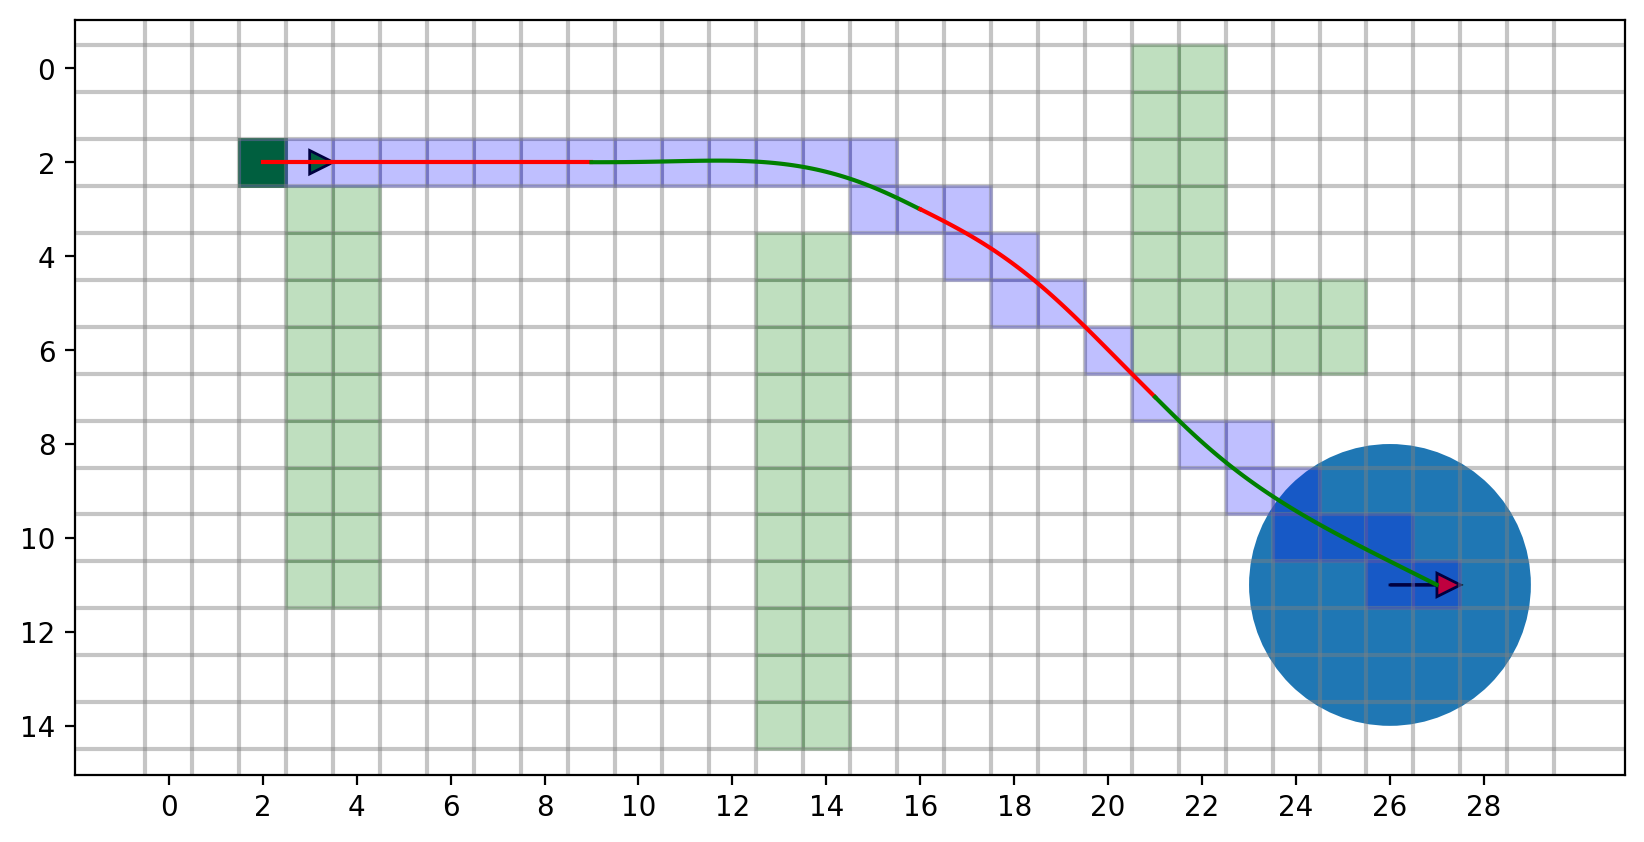

In [48]:
map_str =\
'''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

task_map = Map().convert_string_to_cells(map_str, obs=True)
start = DiscreteState(2, 2, -0)
goal = DiscreteState(11, 26, -0)
params = TypesSearch(task_map, start, goal, types_set)

res = make_path(params)
#res = make_path(params, file="types_ex1.png", dpi=400)

На поиск пути затрачено время: 0.004377841949462891 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 43.24264068711928, финальное состояние: (12 25 [1])
Стоимость примитивов (длина траектории):  34.56727821124493


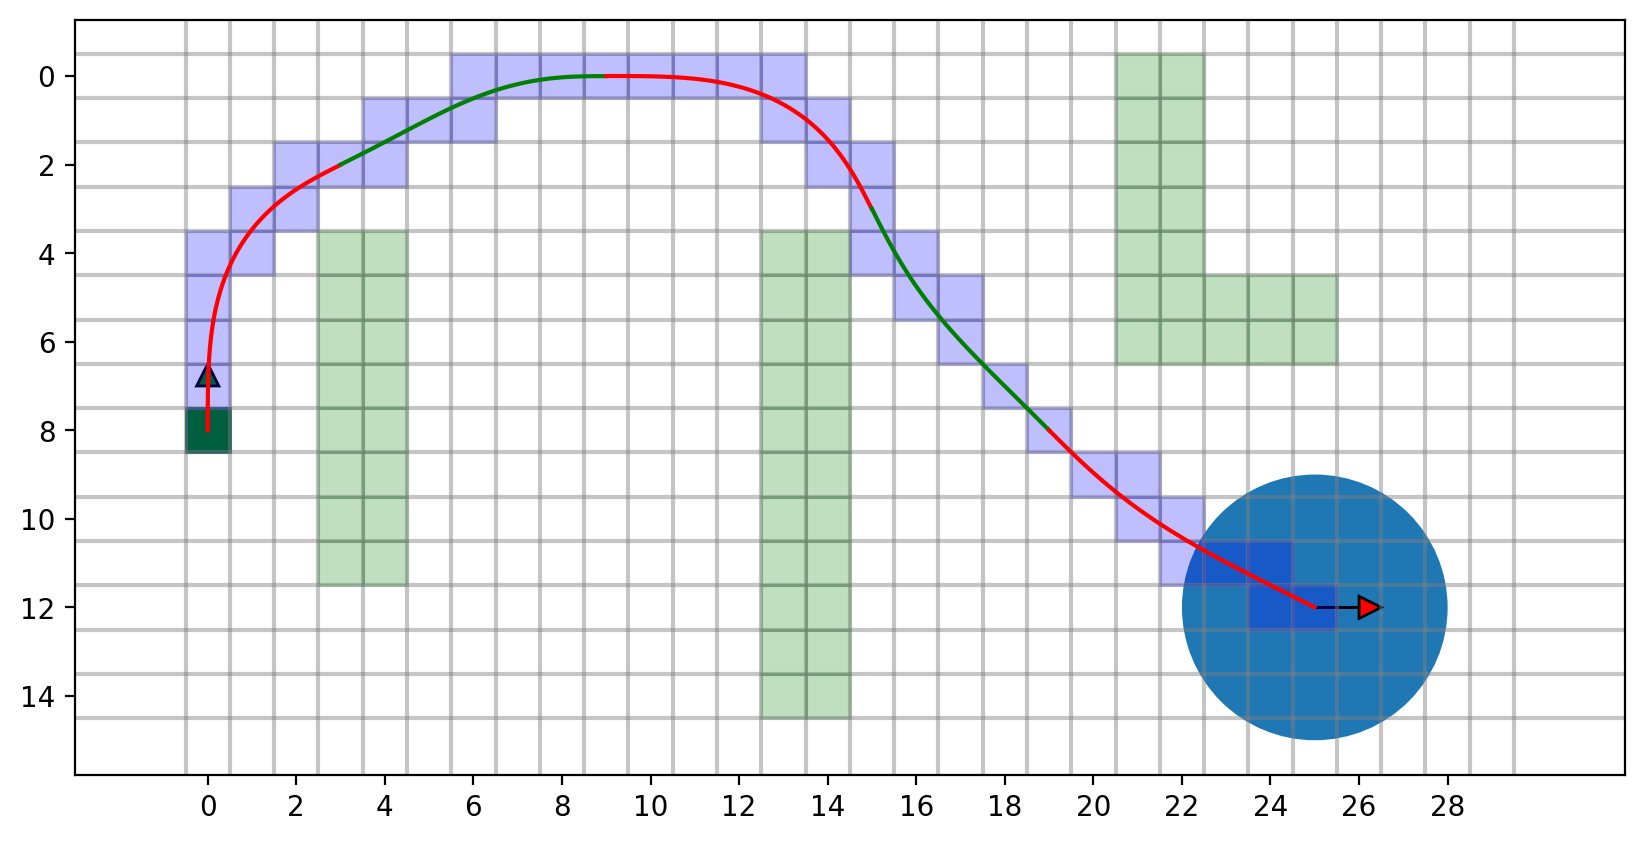

In [49]:
map_str =\
'''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

task_map = Map().convert_string_to_cells(map_str, obs=True)
start = DiscreteState(8, 0, -4)
goal = DiscreteState(12, 25, -0)
params = TypesSearch(task_map, start, goal, types_set)

res = make_path(params)
#res = make_path(params, file="types_ex2.png", dpi=400)

Всего в списке CLOSED оказалось 244 вершин!


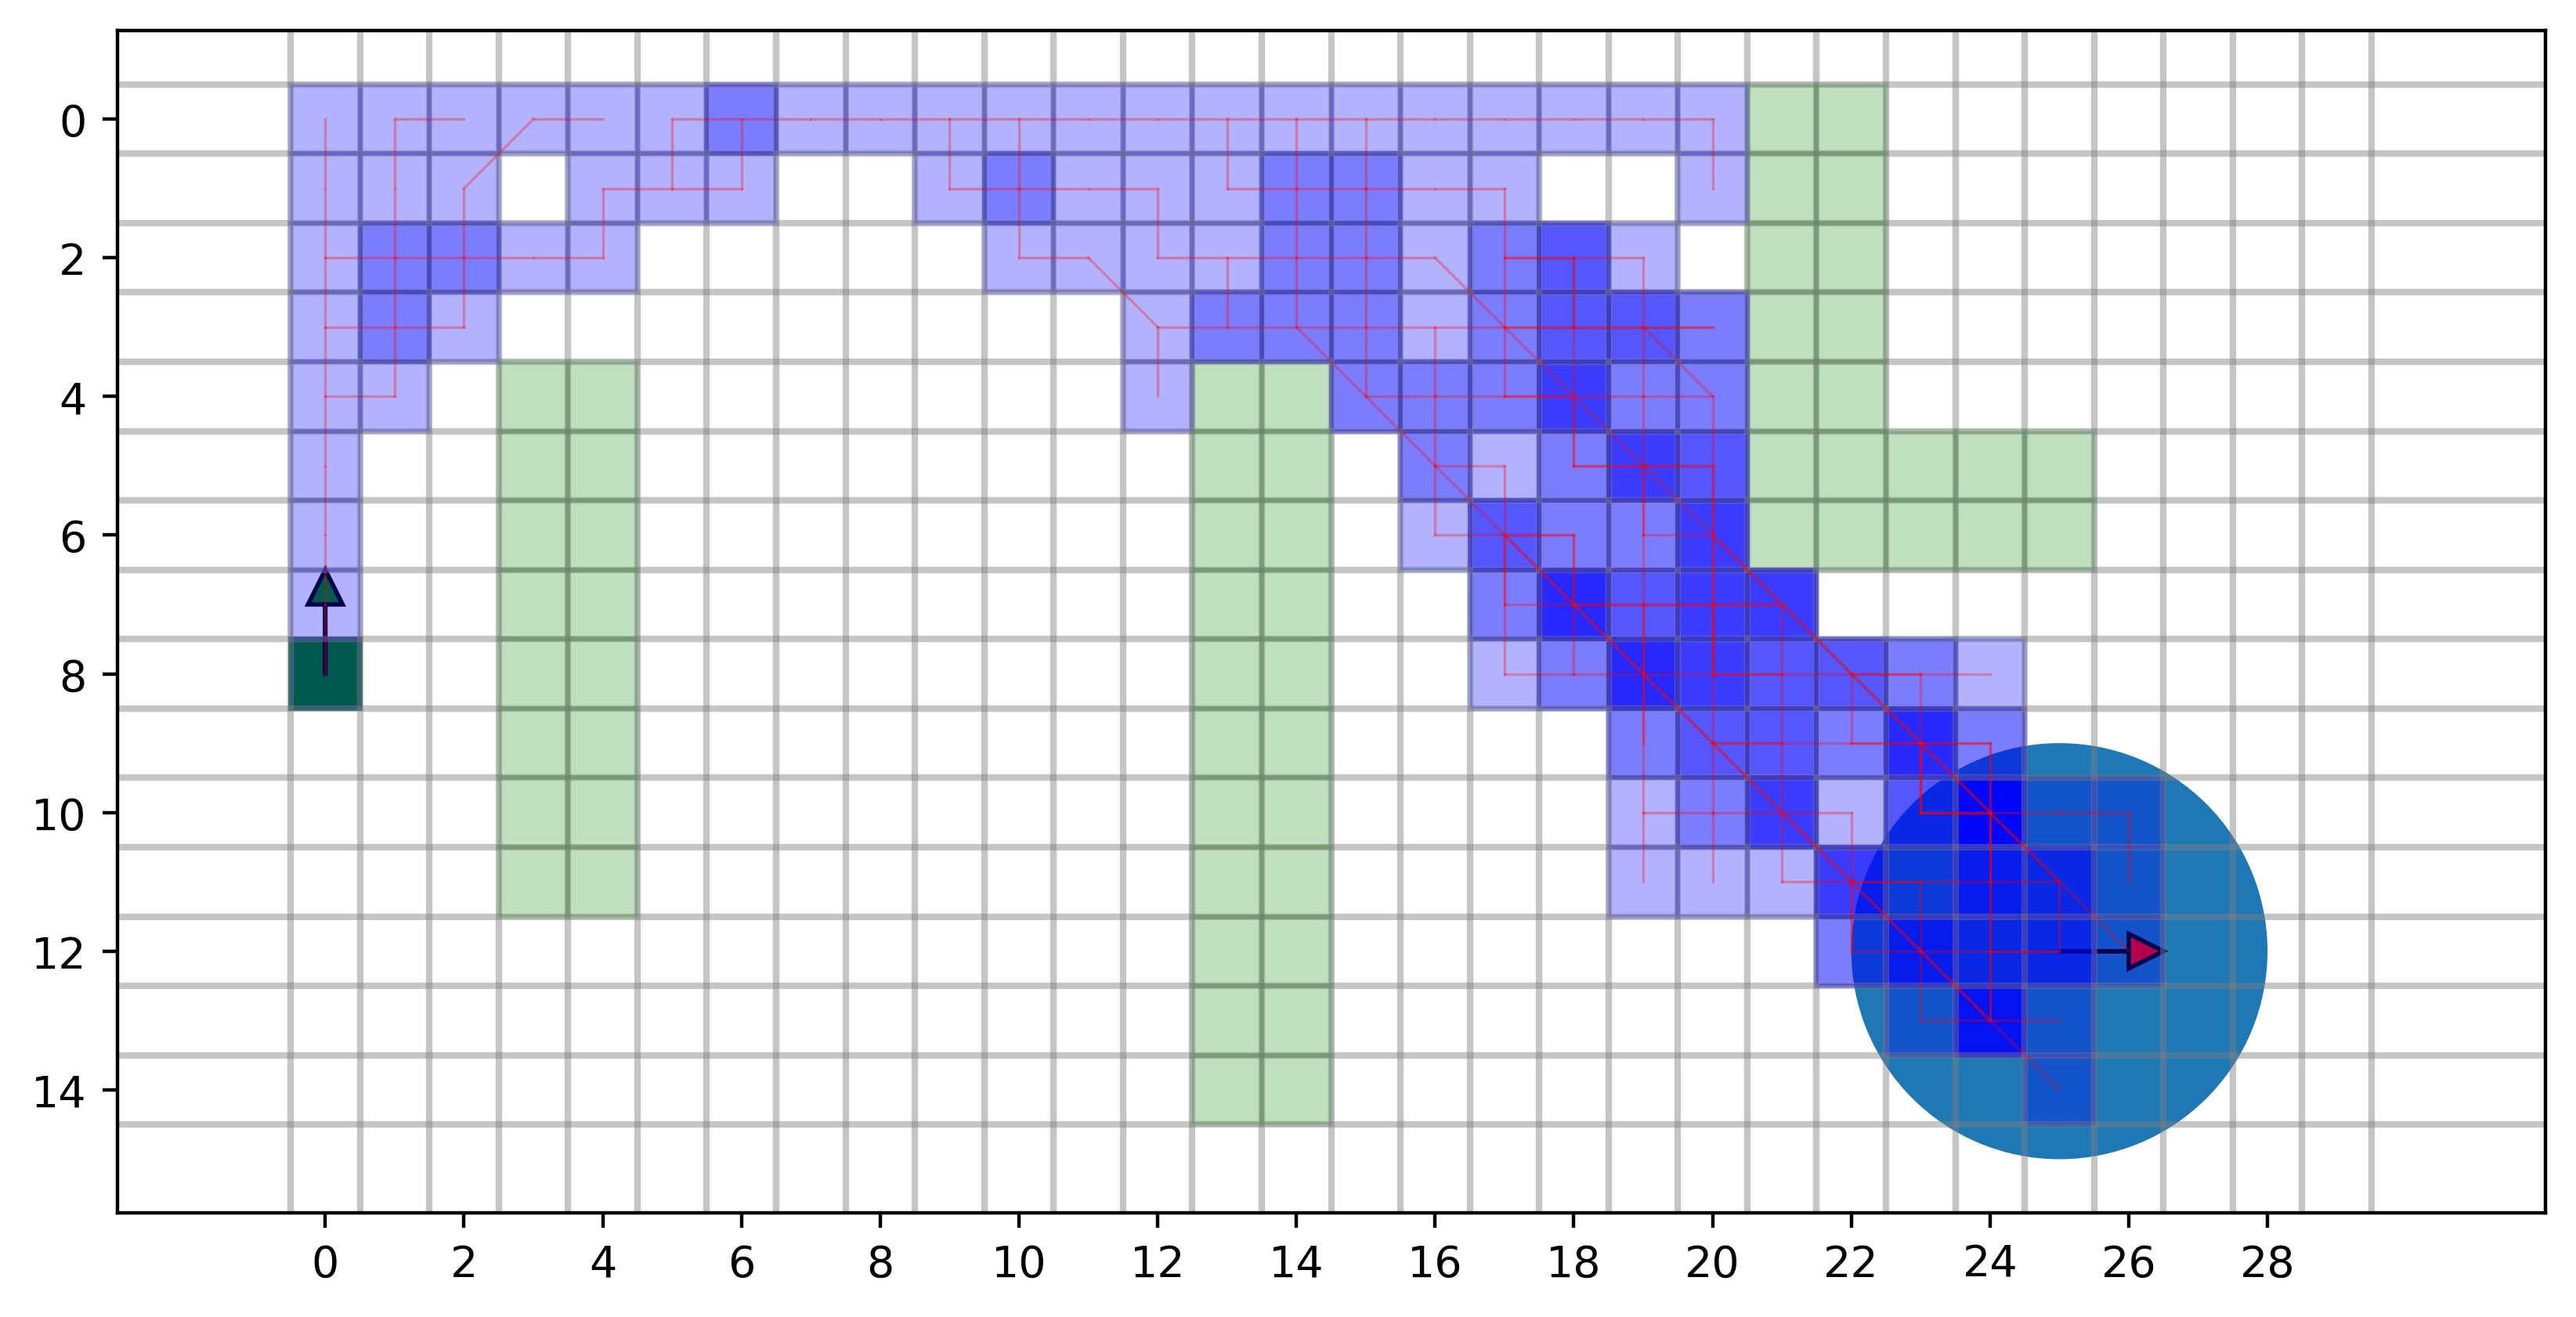

In [50]:
# Посмотрим на список CLOSED.

ax = draw_task_map(params.task_map, params.start, params.finish, dpi=400, A=params.A, R=params.R, theta=params.control_set.theta)

print(f"Всего в списке CLOSED оказалось {len(res[-1])} вершин!")

closed = list(res[-1])
for i in range(len(closed)):
    SN = closed[i]
    ax.add_patch(plt.Rectangle((SN.vertex.j-0.5, SN.vertex.i-0.5), 1, 1, color='b', alpha=0.3))  # рисуем её проекцию
    if SN.parent:
        ax.plot([SN.parent.vertex.j, SN.vertex.j], [SN.parent.vertex.i, SN.vertex.i], 1, 1, color='r', alpha=0.3, linewidth=0.6)

#plt.savefig("types_closed_2.png", transparent=False, facecolor='white')
plt.show()

На поиск пути затрачено время: 1.5873684883117676 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 91.3847763108502, финальное состояние: (53 49 [8])
Стоимость примитивов (длина траектории):  84.2232815053682


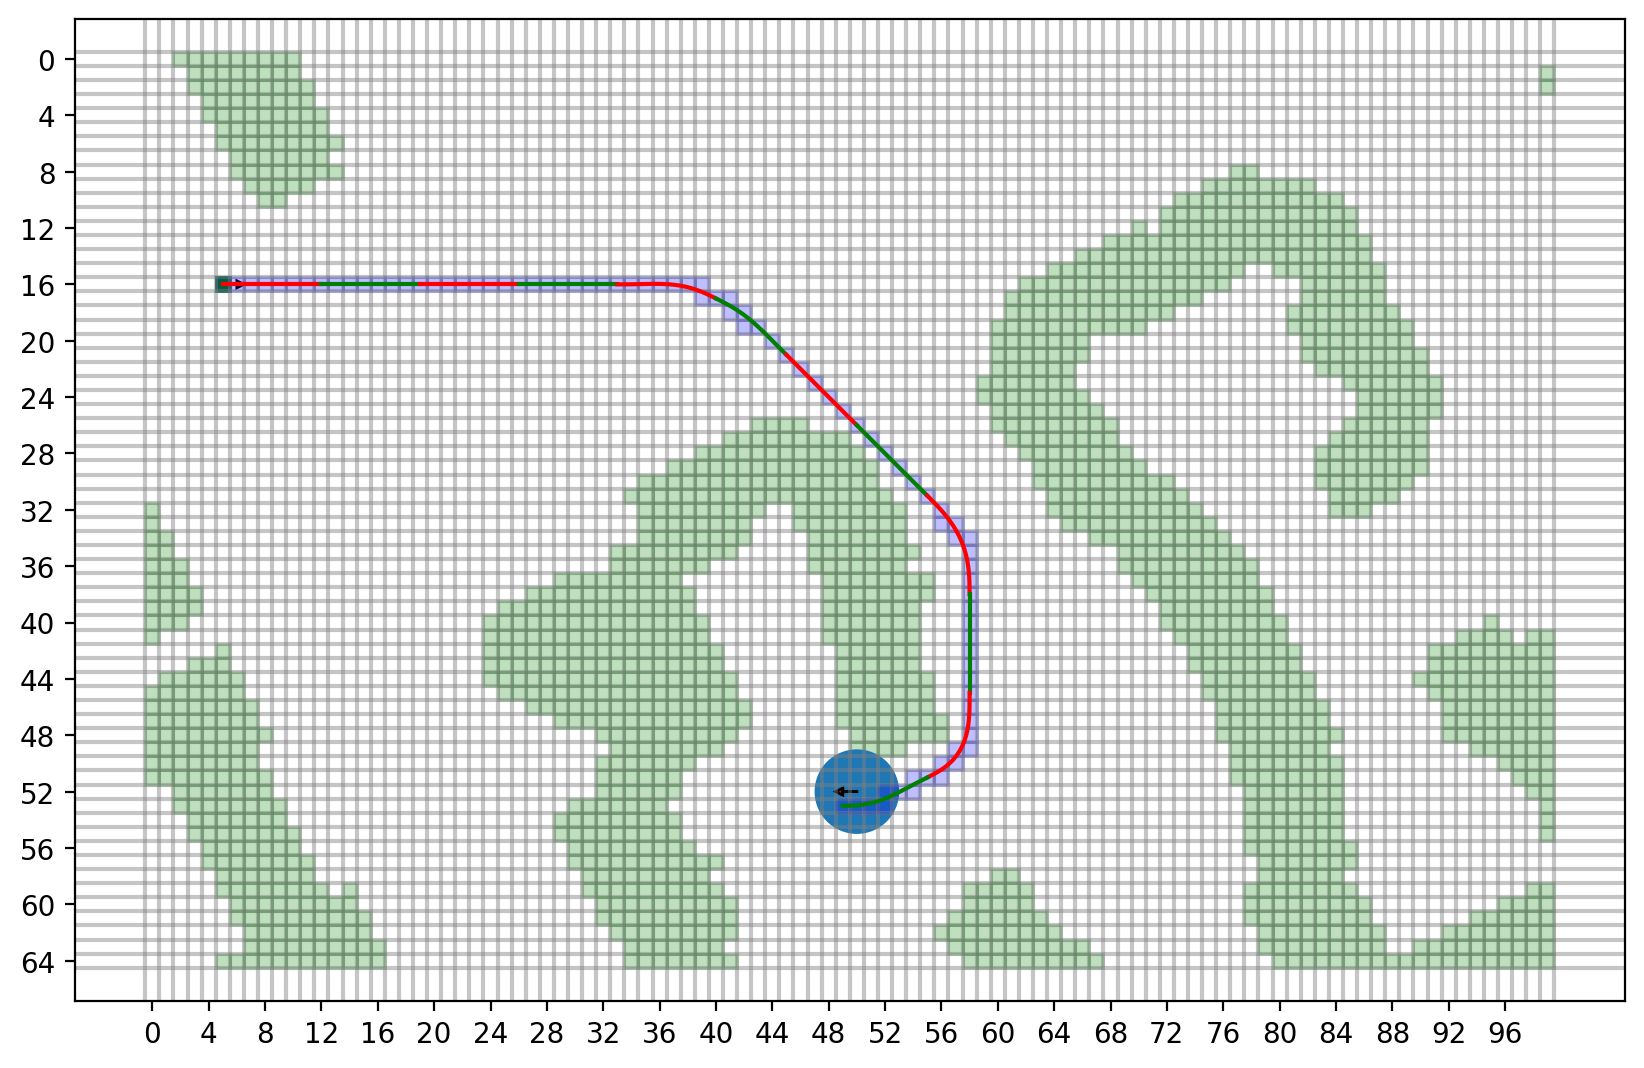

In [51]:
with open("Berlin_256.txt", "r") as f:
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(25,90, 50,150)
start = DiscreteState(16, 5, -0)
goal = DiscreteState(52, 50, -8) # State(56, 93, 0, -1)
params = TypesSearch(task_map, start, goal, types_set)

res = make_path(params)
#res = make_path(params, file="types_ex3.png", dpi=400)

Всего в списке CLOSED оказалось 96580 вершин!


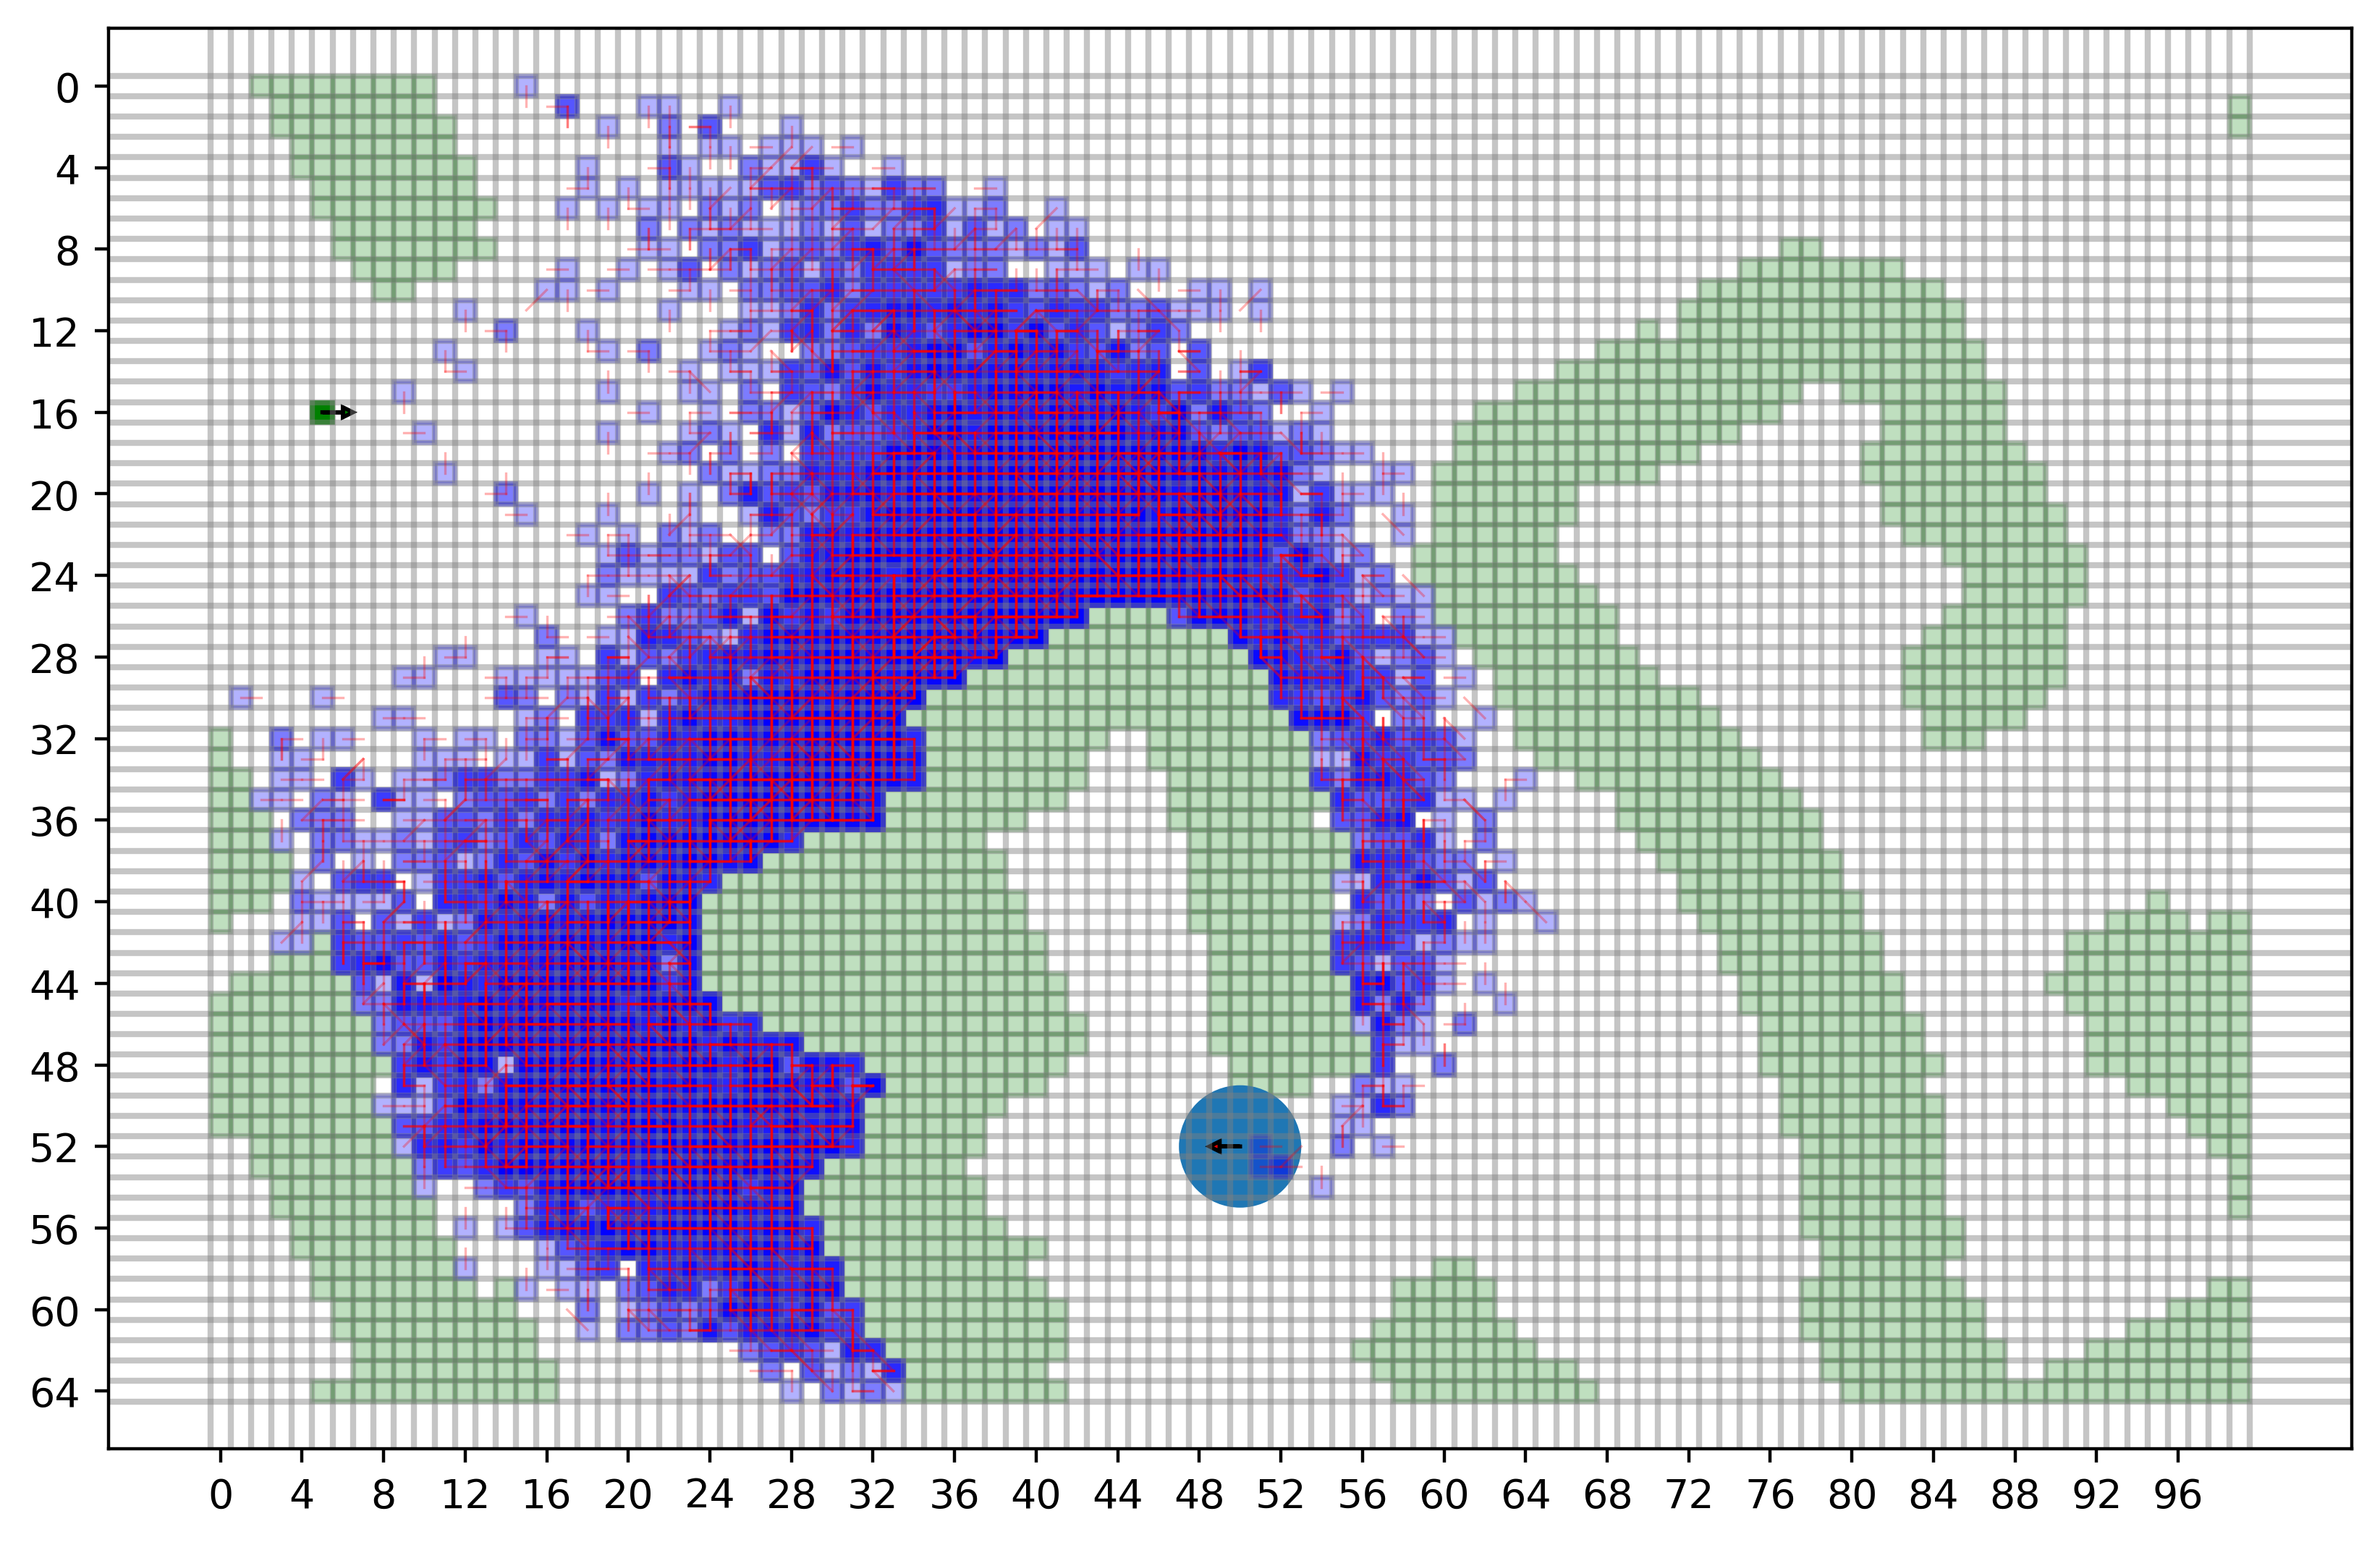

In [52]:
# Посмотрим на список CLOSED (на проекцию его вершин на карту)

# рисуем карту
ax = draw_task_map(params.task_map, params.start, params.finish, dpi=400, A=params.A, R=params.R, theta=params.control_set.theta)

print(f"Всего в списке CLOSED оказалось {len(res[-1])} вершин!")

closed = list(res[-1])[::10]  # берём каждую 10-ую вершину
for i in range(len(closed)):
    SN = closed[i]  # берём очередную Seacrh Node
    ax.add_patch(plt.Rectangle((SN.vertex.j-0.5, SN.vertex.i-0.5), 1, 1, color='b', alpha=0.3))  # рисуем её проекцию
    if SN.parent:  # рисуем ребро в родителя
        ax.plot([SN.parent.vertex.j, SN.vertex.j], [SN.parent.vertex.i, SN.vertex.i], 1, 1, color='r', alpha=0.3, linewidth=0.6)

#plt.savefig("types_closed_3.png", transparent=False, facecolor='white')
plt.show()

На поиск пути затрачено время: 18.12274479866028 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 268.7817459305204, финальное состояние: (29 232 [13])
Стоимость примитивов (длина траектории):  249.84392636840403


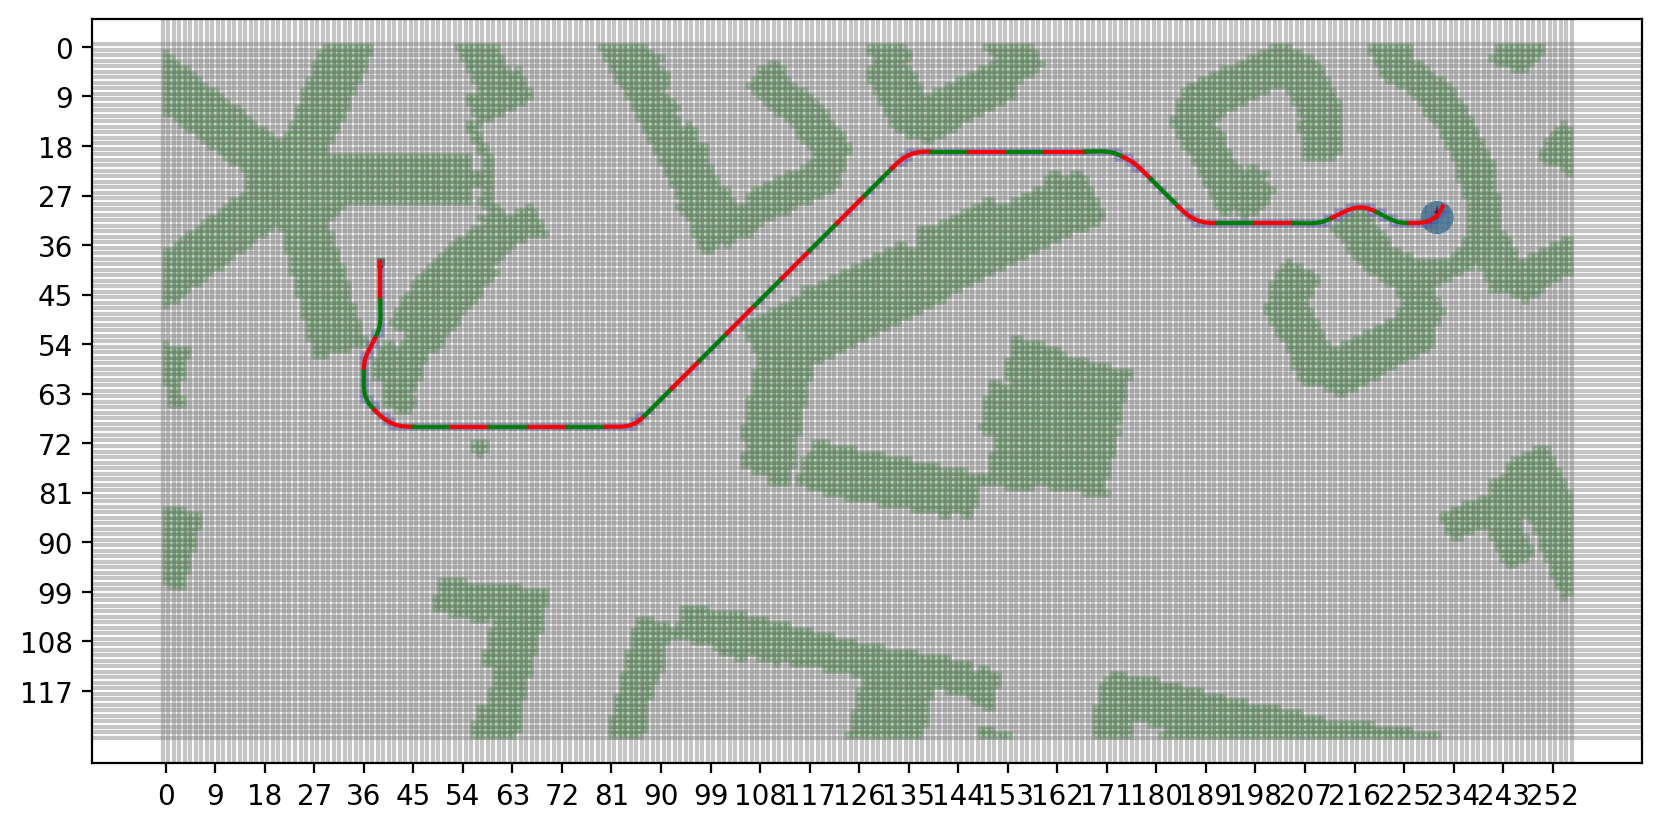

In [53]:
with open("Berlin_256.txt", "r") as f:
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(80,-50,0,1000)
start = DiscreteState(39, 39, -12)
goal = DiscreteState(31, 231, -4)
params = TypesSearch(task_map, start, goal, types_set)

path = make_path(params)
#res = make_path(params, file="types_ex4.png", dpi=400)

### Модификация склеиванием. Примеры:
Далее будут те же карты, что и до этого. Отличается только склеивание вершин.

In [54]:
"""
Модификация склеиванием заключается в том, что мы отождеставляем некоторые вершины в списке CLOSED. Так как 
за вставку в него (и сравнение с другими элементами) отвечают только функции __eq__ и __hash__, то единственное,
что нужно изменить - это у вершины (в качестве которой TypeMesh, типовая ячейка) заменить данные функции на те,
что будут отождествлять некоторые вершины, склиевать их. В качестве информации для склеивания у нас заранее
имеется add_info, которая была сгенерирована для каждого типа. Согласно диплому, add_info (информация, на основе
которой склеиваем вершины) состоит из угла типа и характеристики типа.
"""

def bonding_eq(self: TypeMesh, other: TypeMesh) -> bool:  # равными (= склеенными) в списке CLOSED считаем вершины с одинаковыми координатами и одинаковой доп информацией (углом типа и характеристикой типа) 
    return (self.i == other.i) and (self.j == other.j) and (types_set.add_info_type[self.type] == types_set.add_info_type[other.type])

def bonding_hash(self: TypeMesh) -> int:  # аналогично хешируем
    return hash((self.i, self.j, types_set.add_info_type[self.type]))

TypeMesh.__eq__ = bonding_eq  # обновляем функции на новые
TypeMesh.__hash__ = bonding_hash

"""
Таким образом, функции __eq__ и __hash__ занимаются склеиванием вершин. Просто обычно они склеивают вершину только саму с собой (для стандартного
поиска), а здесь скливаем разные вершины с одинаковой доп информацией. 
"""
None

На поиск пути затрачено время: 0.01664590835571289 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 32.24264068711929, финальное состояние: (11 27 [1])
Стоимость примитивов (длина траектории):  27.843319964394574


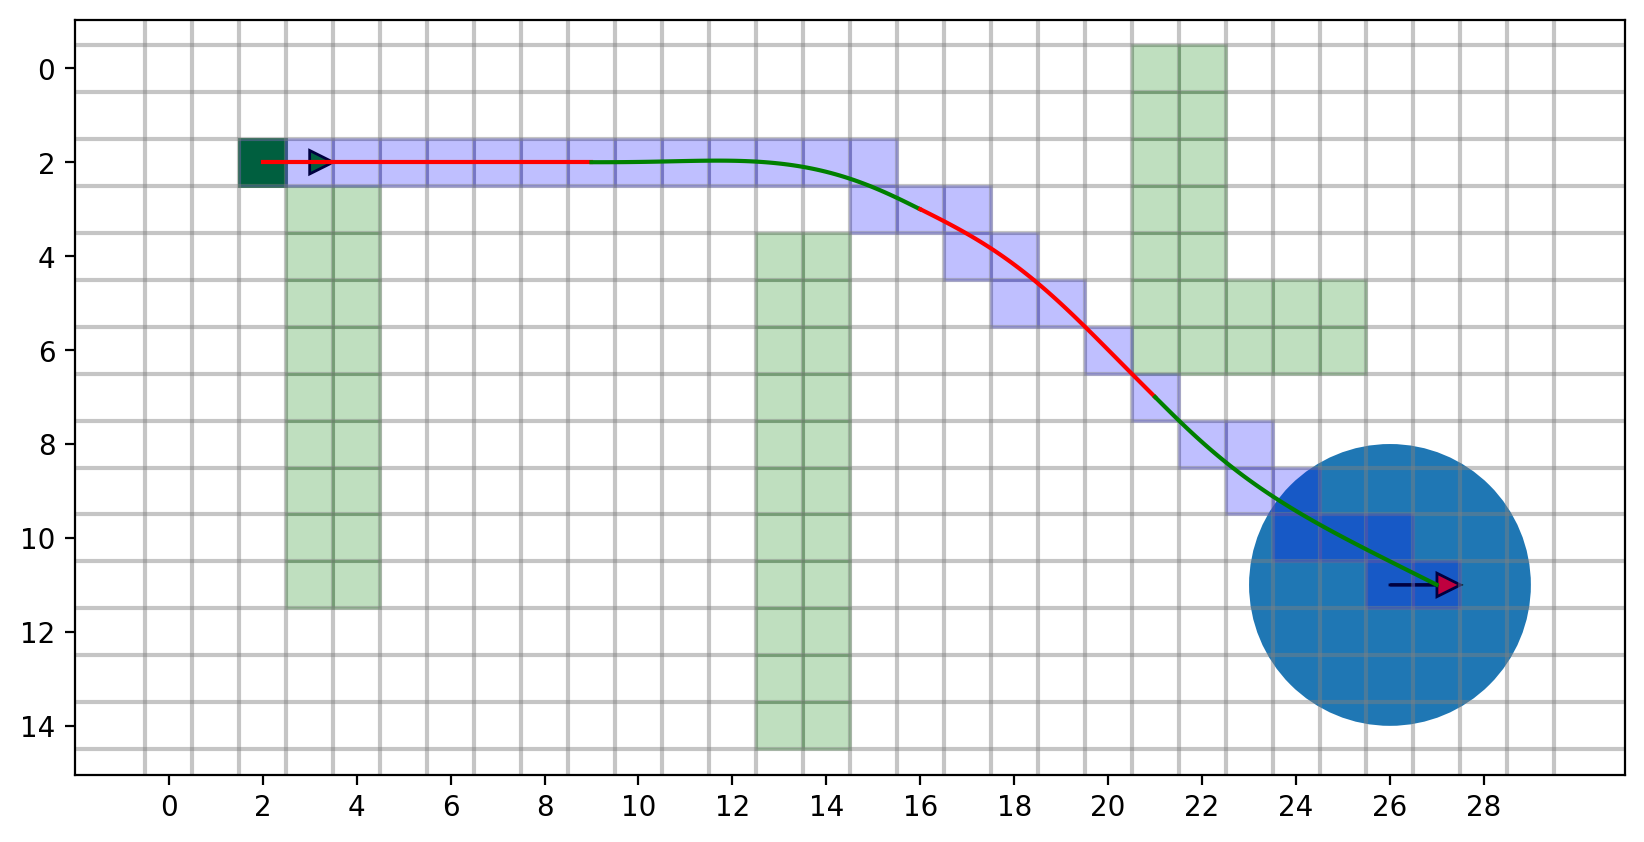

In [55]:
map_str =\
'''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

task_map = Map().convert_string_to_cells(map_str, obs=True)
start = DiscreteState(2, 2, -0)
goal = DiscreteState(11, 26, -0)
params = TypesSearch(task_map, start, goal, types_set)

res = make_path(params)

На поиск пути затрачено время: 0.0074748992919921875 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 42.48528137423857, финальное состояние: (11 27 [1])
Стоимость примитивов (длина траектории):  35.52546340219541


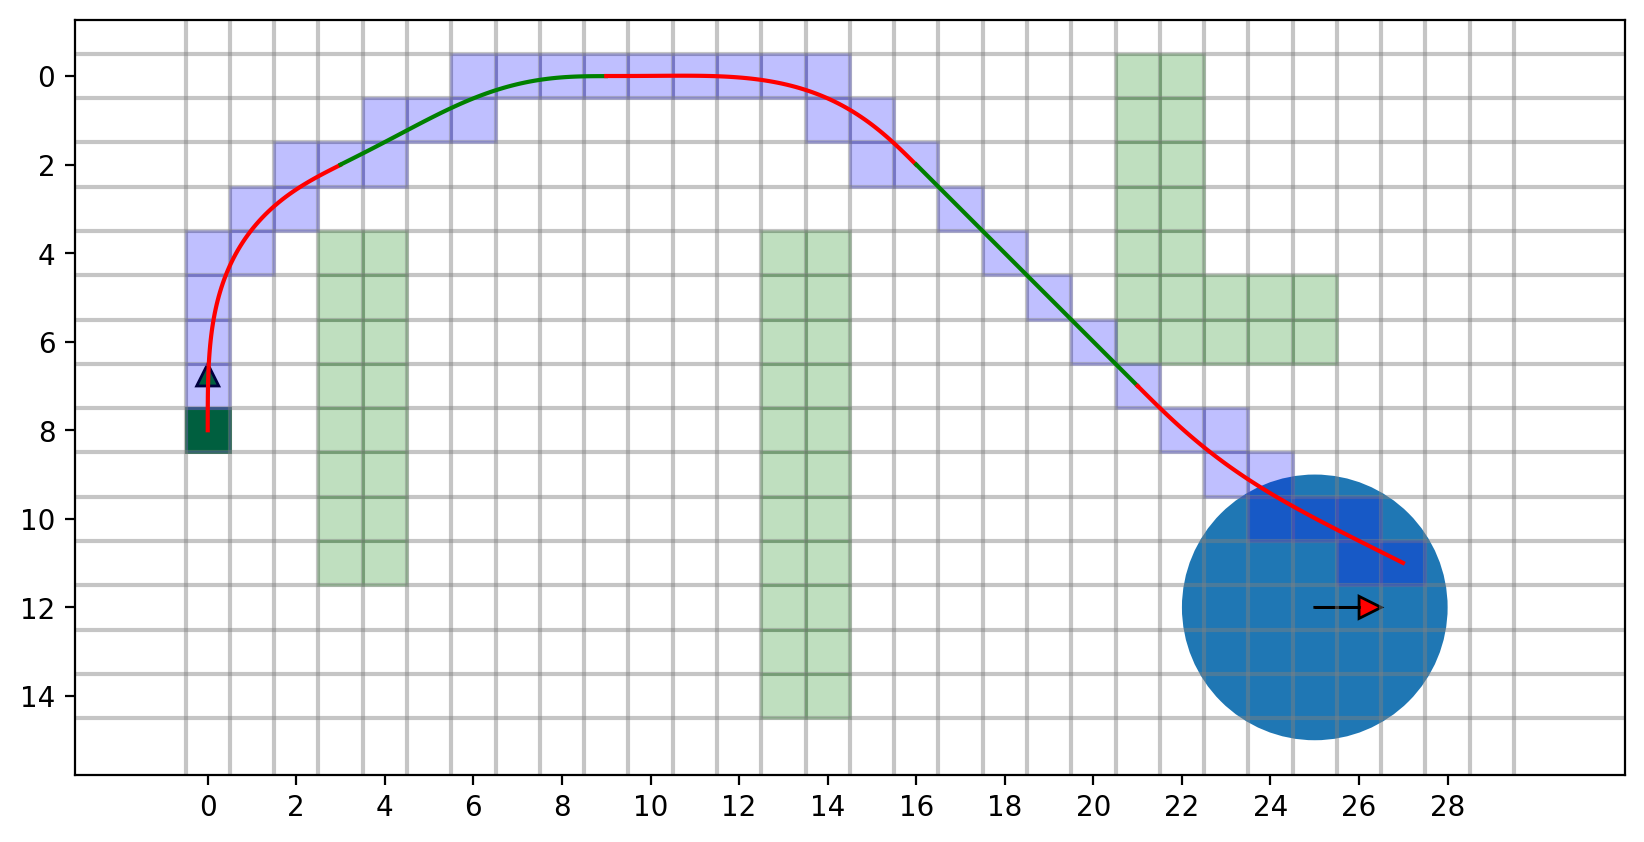

In [56]:
map_str =\
'''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

task_map = Map().convert_string_to_cells(map_str, obs=True)
start = DiscreteState(8, 0, -4)
goal = DiscreteState(12, 25, -0)
params = TypesSearch(task_map, start, goal, types_set)

res = make_path(params)

На поиск пути затрачено время: 0.16833162307739258 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 91.3847763108502, финальное состояние: (53 49 [8])
Стоимость примитивов (длина траектории):  84.2232815053682


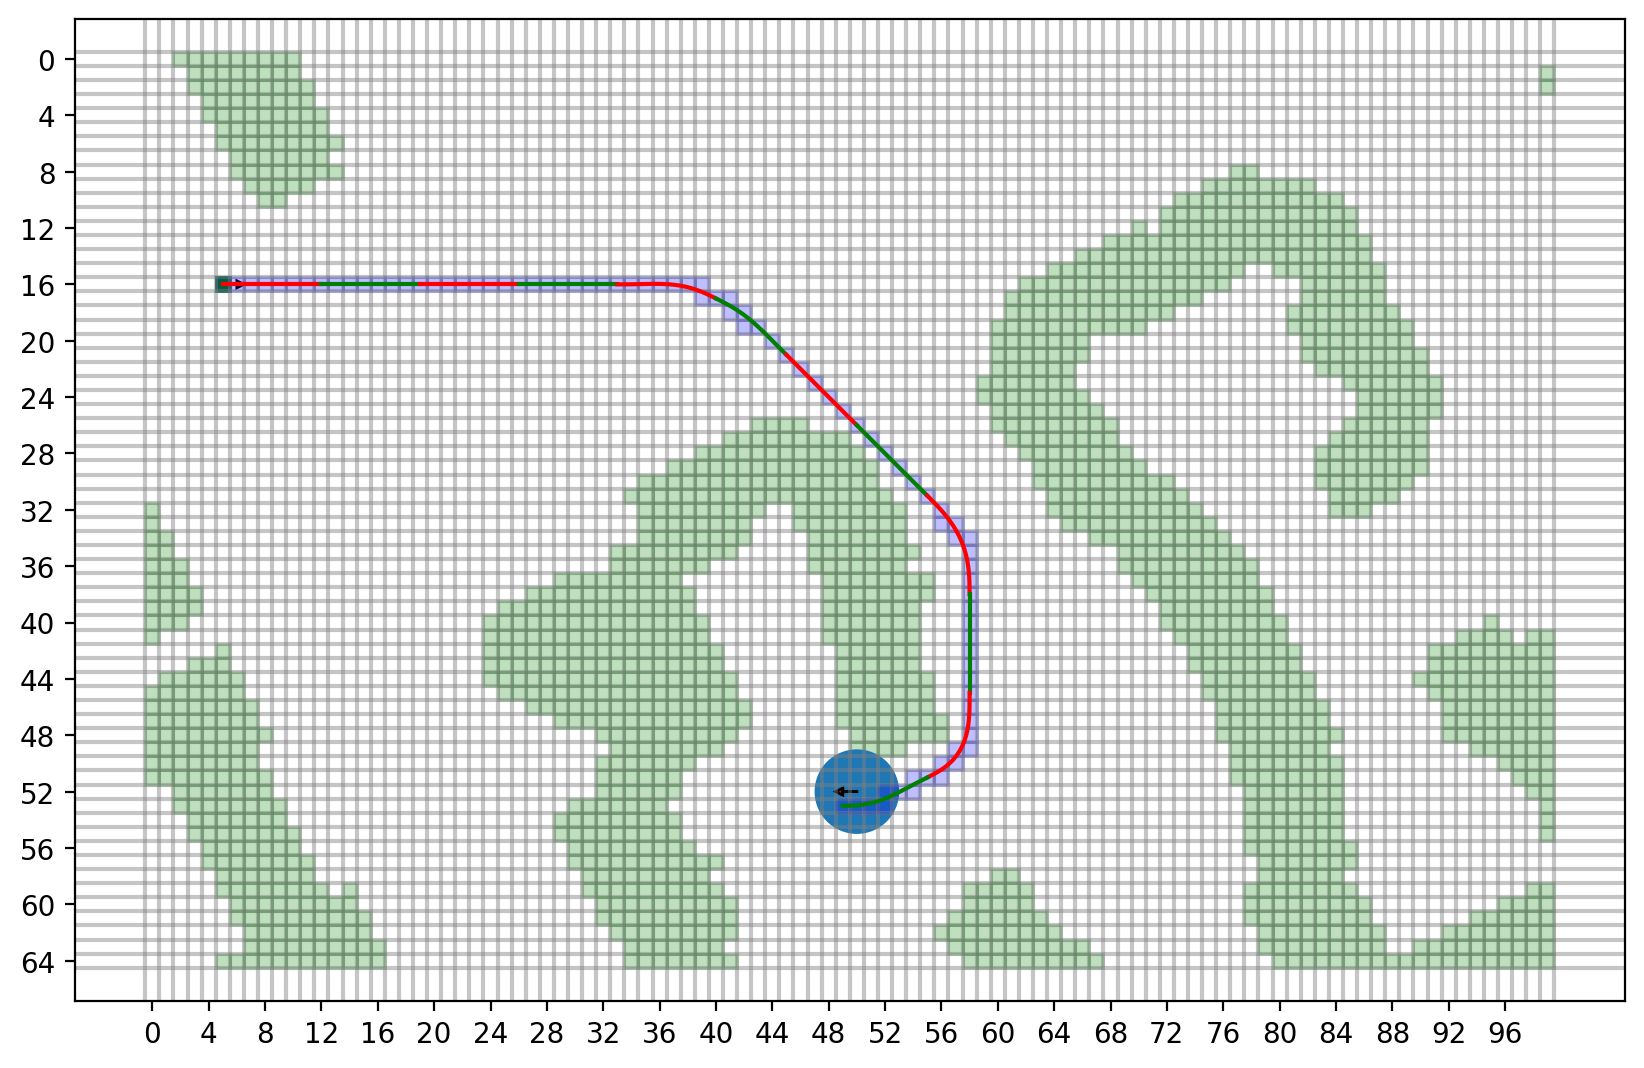

In [57]:
with open("Berlin_256.txt", "r") as f:
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(25,90, 50,150)
start = DiscreteState(16, 5, -0)
goal = DiscreteState(52, 50, -8) # State(56, 93, 0, -1)
params = TypesSearch(task_map, start, goal, types_set)

res = make_path(params)

Всего в списке CLOSED оказалось 12411 вершин!


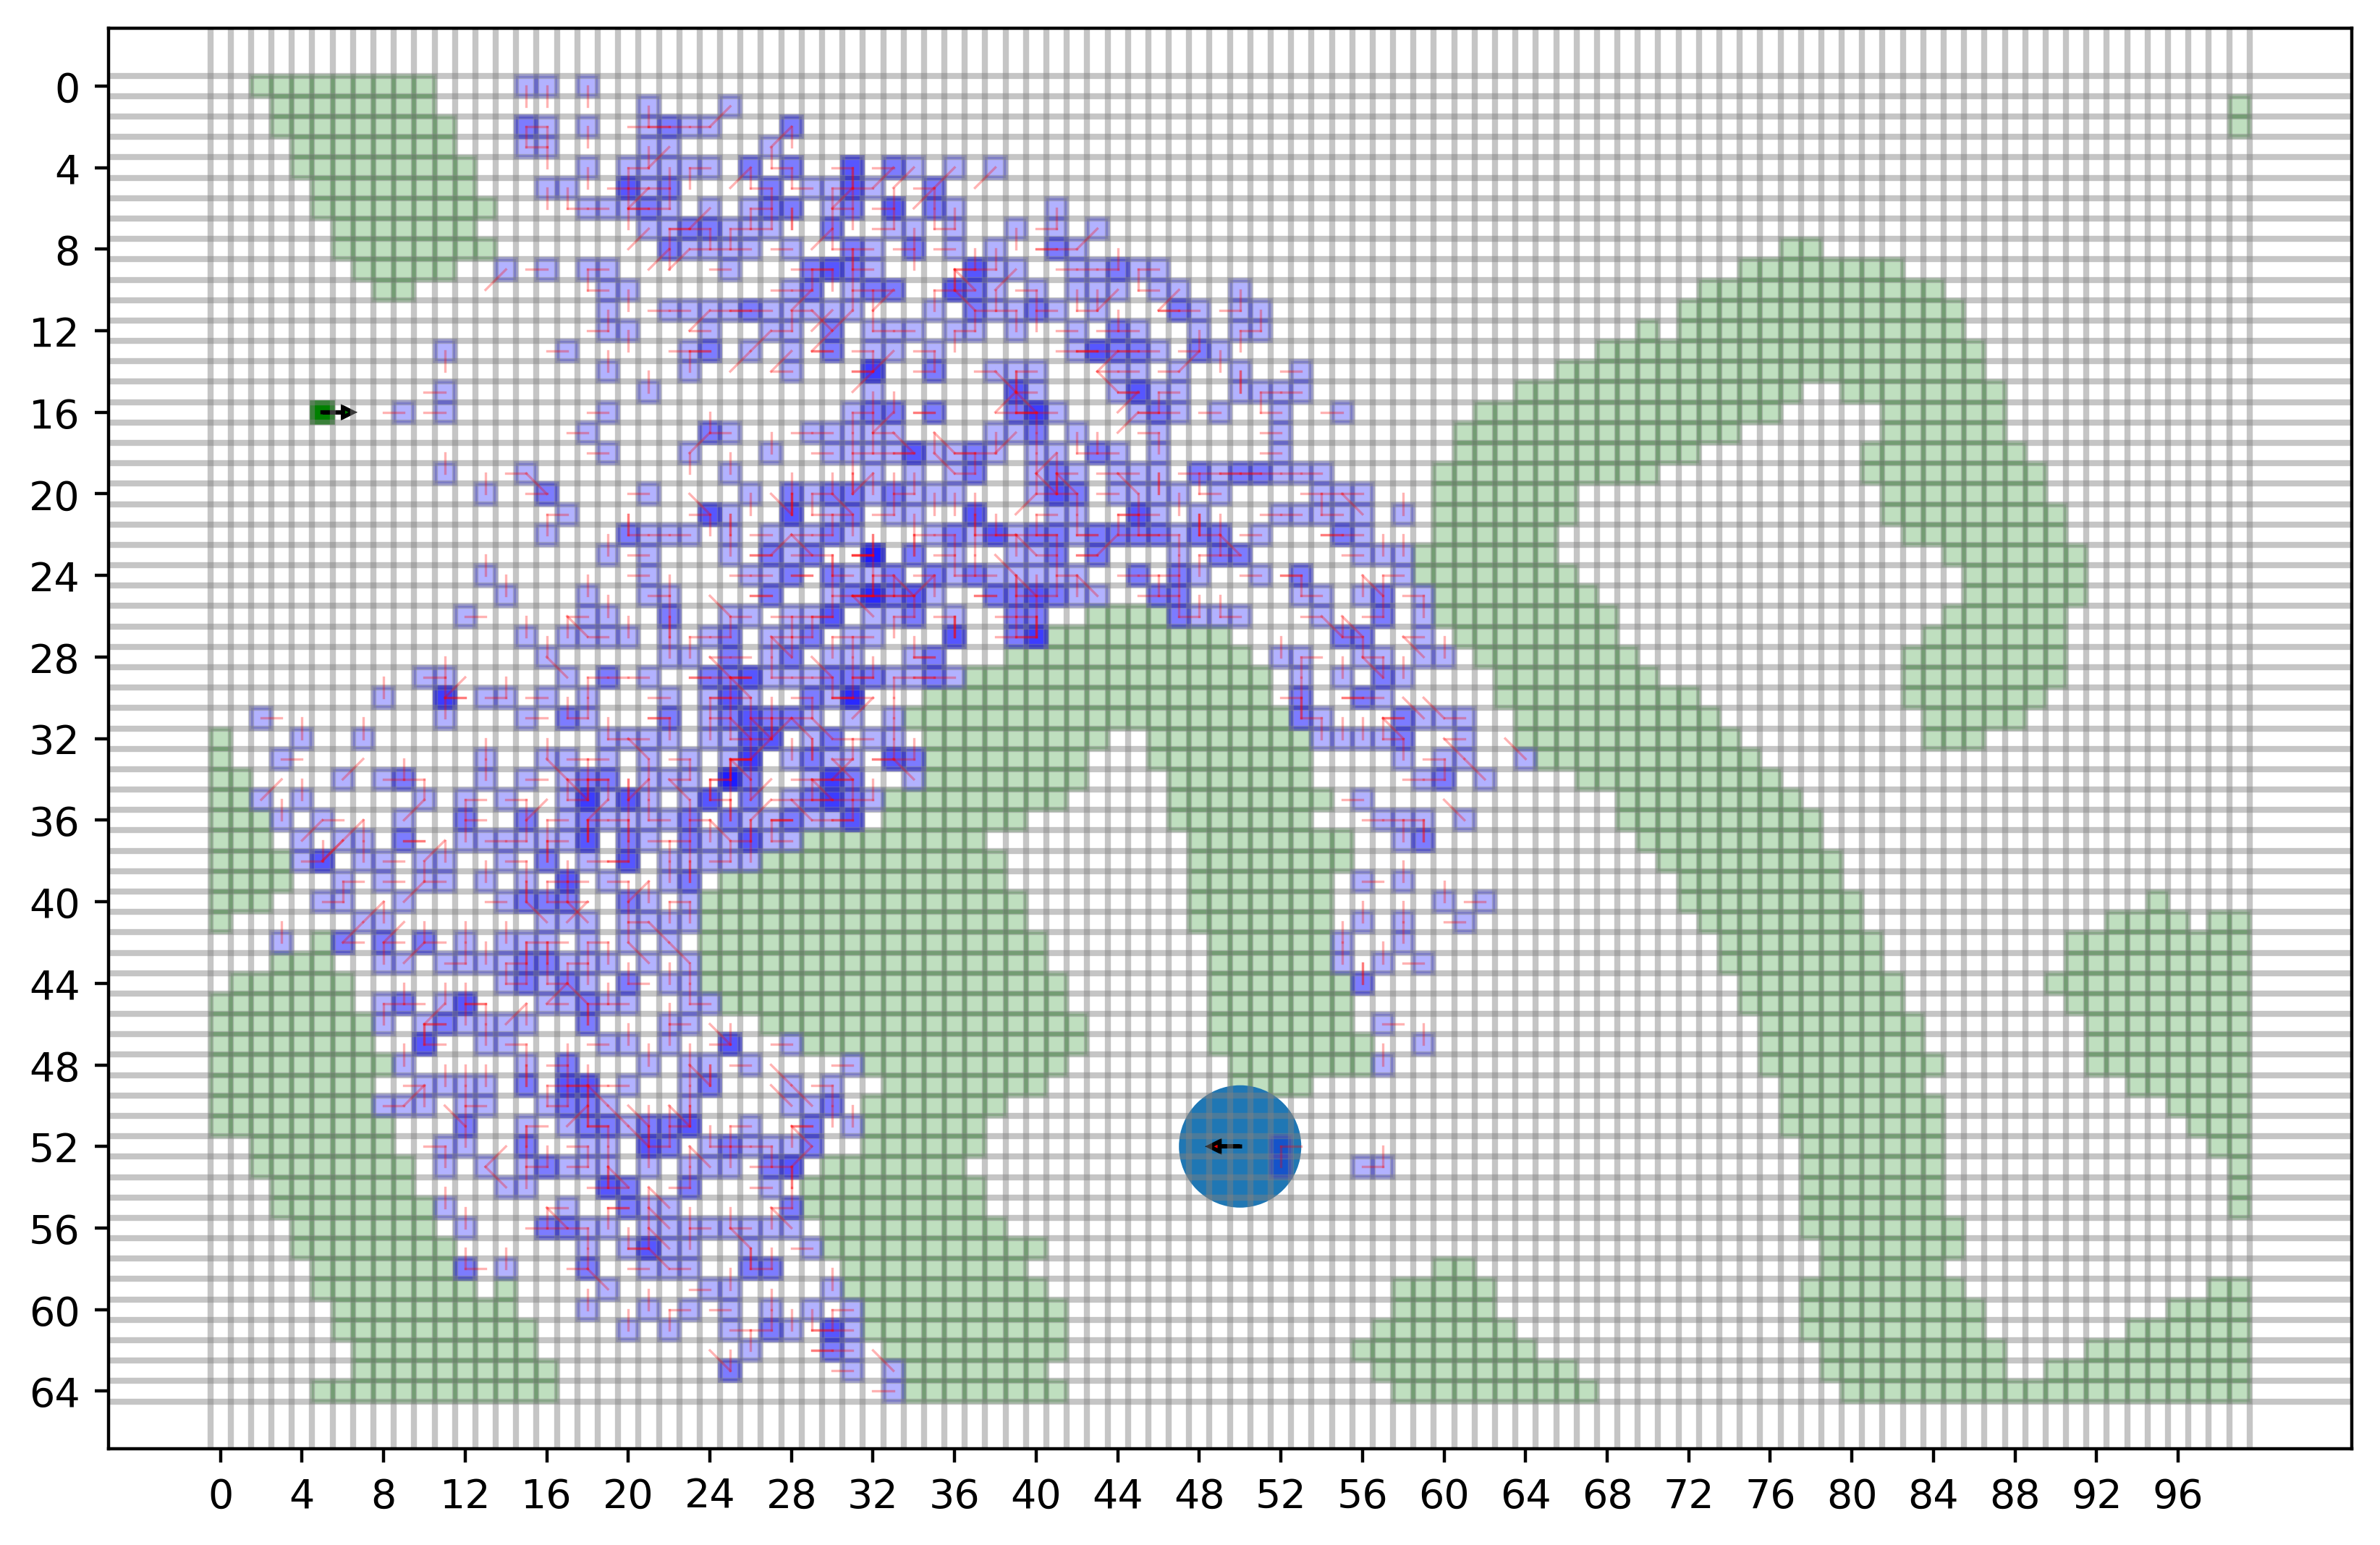

In [58]:
# Снова посмотрим на список CLOSED, чтобы сравнить, как он меняется при модификации склеиванием.

ax = draw_task_map(params.task_map, params.start, params.finish, dpi=400, A=params.A, R=params.R, theta=params.control_set.theta)

print(f"Всего в списке CLOSED оказалось {len(res[-1])} вершин!")

closed = list(res[-1])[::10]
for i in range(len(closed)):
    SN = closed[i]
    ax.add_patch(plt.Rectangle((SN.vertex.j-0.5, SN.vertex.i-0.5), 1, 1, color='b', alpha=0.3))  # рисуем её проекцию
    if SN.parent:
        ax.plot([SN.parent.vertex.j, SN.vertex.j], [SN.parent.vertex.i, SN.vertex.i], 1, 1, color='r', alpha=0.3, linewidth=0.6)

#plt.savefig("types_approx_3.png", transparent=False, facecolor='white')
plt.show()

На поиск пути затрачено время: 1.0735790729522705 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 270.5391052434011, финальное состояние: (28 231 [13])
Стоимость примитивов (длина траектории):  248.41030258009803


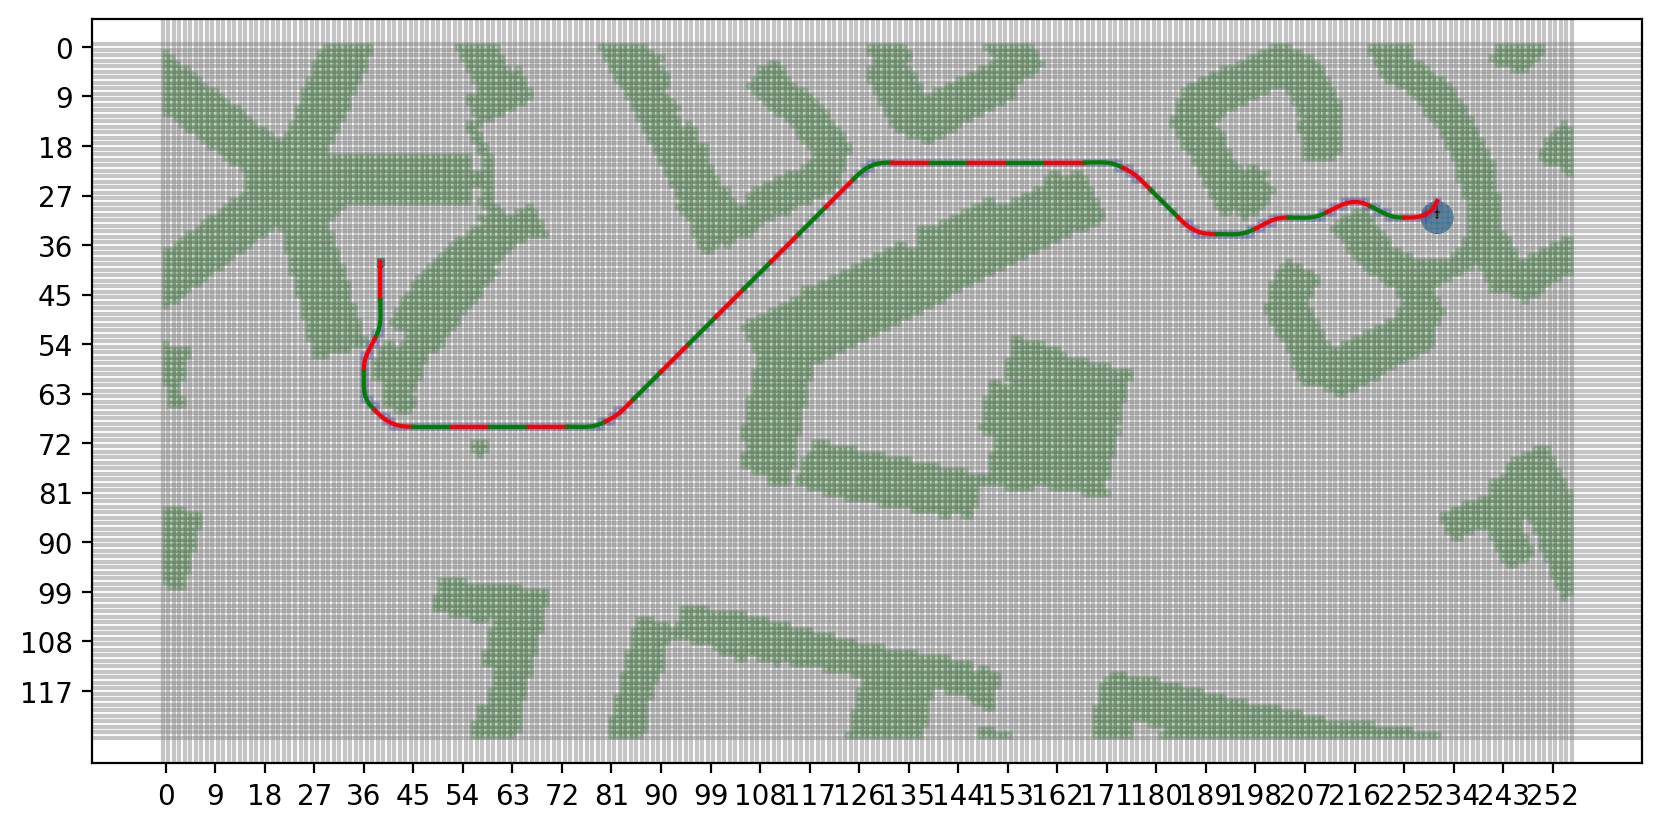

In [59]:
with open("Berlin_256.txt", "r") as f:
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(80,-50,0,1000)
start = DiscreteState(39, 39, -12)
goal = DiscreteState(31, 231, -4)
params = TypesSearch(task_map, start, goal, types_set)

path = make_path(params)

### Теперь с другими примитивами:

In [60]:
theta_16 = Theta()
big_control_set = ControlSet(theta_16).load_primitives("big_control_set.txt")  # большой control set
short_control_set = ControlSet(theta_16).load_primitives("short_control_set.txt")  # маленький control set
big_types = TypeInfo(big_control_set).load_types("big_types.txt")  # загрузили соответствующие типы
short_types = TypeInfo(short_control_set).load_types("short_types.txt")  # загрузили соответствующие типы

#### Сначала используем маленький control set

для этого снова обновляем функции, чтобы они склеивали с помощью нужного набора типов

In [69]:
def short_bonding_eq(self: TypeMesh, other: TypeMesh) -> bool:
    return (self.i == other.i) and (self.j == other.j) and (short_types.add_info_type[self.type] == short_types.add_info_type[other.type])

def short_bonding_hash(self: TypeMesh) -> int:
    return hash((self.i, self.j, short_types.add_info_type[self.type]))  # использум везде типы короткого набора control_set

TypeMesh.__eq__ = short_bonding_eq 
TypeMesh.__hash__ = short_bonding_hash

На поиск пути затрачено время: 0.012420415878295898 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 27.485281374238575, финальное состояние: (10 25 [1])
Стоимость примитивов (длина траектории):  25.958861762677145


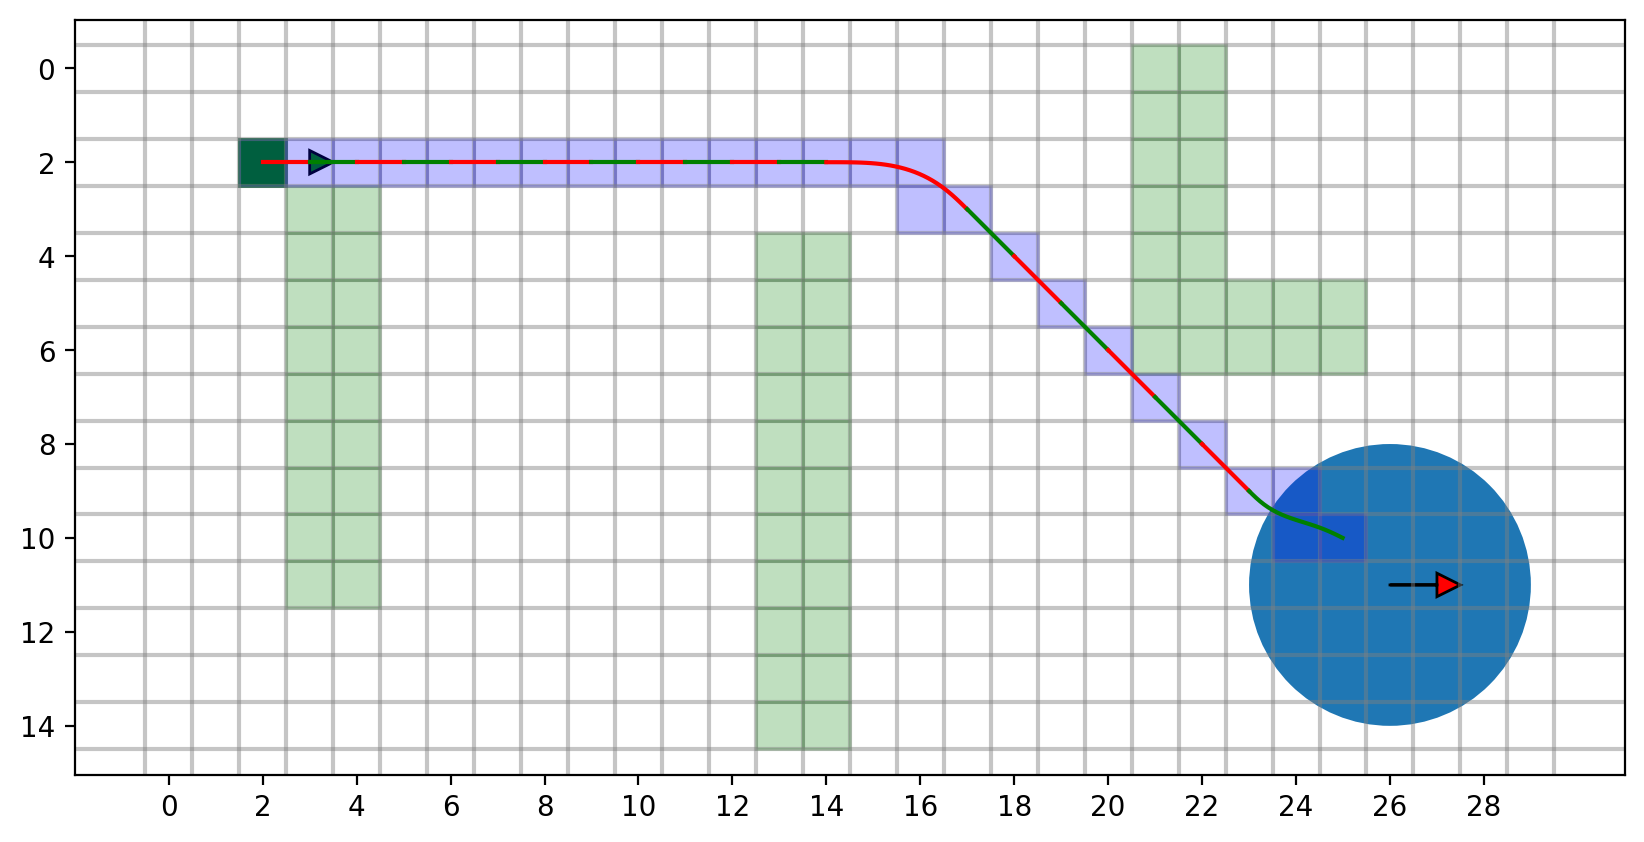

In [62]:
# Сначала посмотрим на самый первый пример

map_str =\
'''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

task_map = Map().convert_string_to_cells(map_str, obs=True)
start = DiscreteState(2, 2, -0)
goal = DiscreteState(11, 26, -0)
params = TypesSearch(task_map, start, goal, short_types)  # едиснтвенное, что меняется - используем типы для short_sontrol_set
res = make_path(params)

На поиск пути затрачено время: 1.1191647052764893 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 82.04163056034257, финальное состояние: (52 53 [7])
Стоимость примитивов (длина траектории):  78.96571010702675


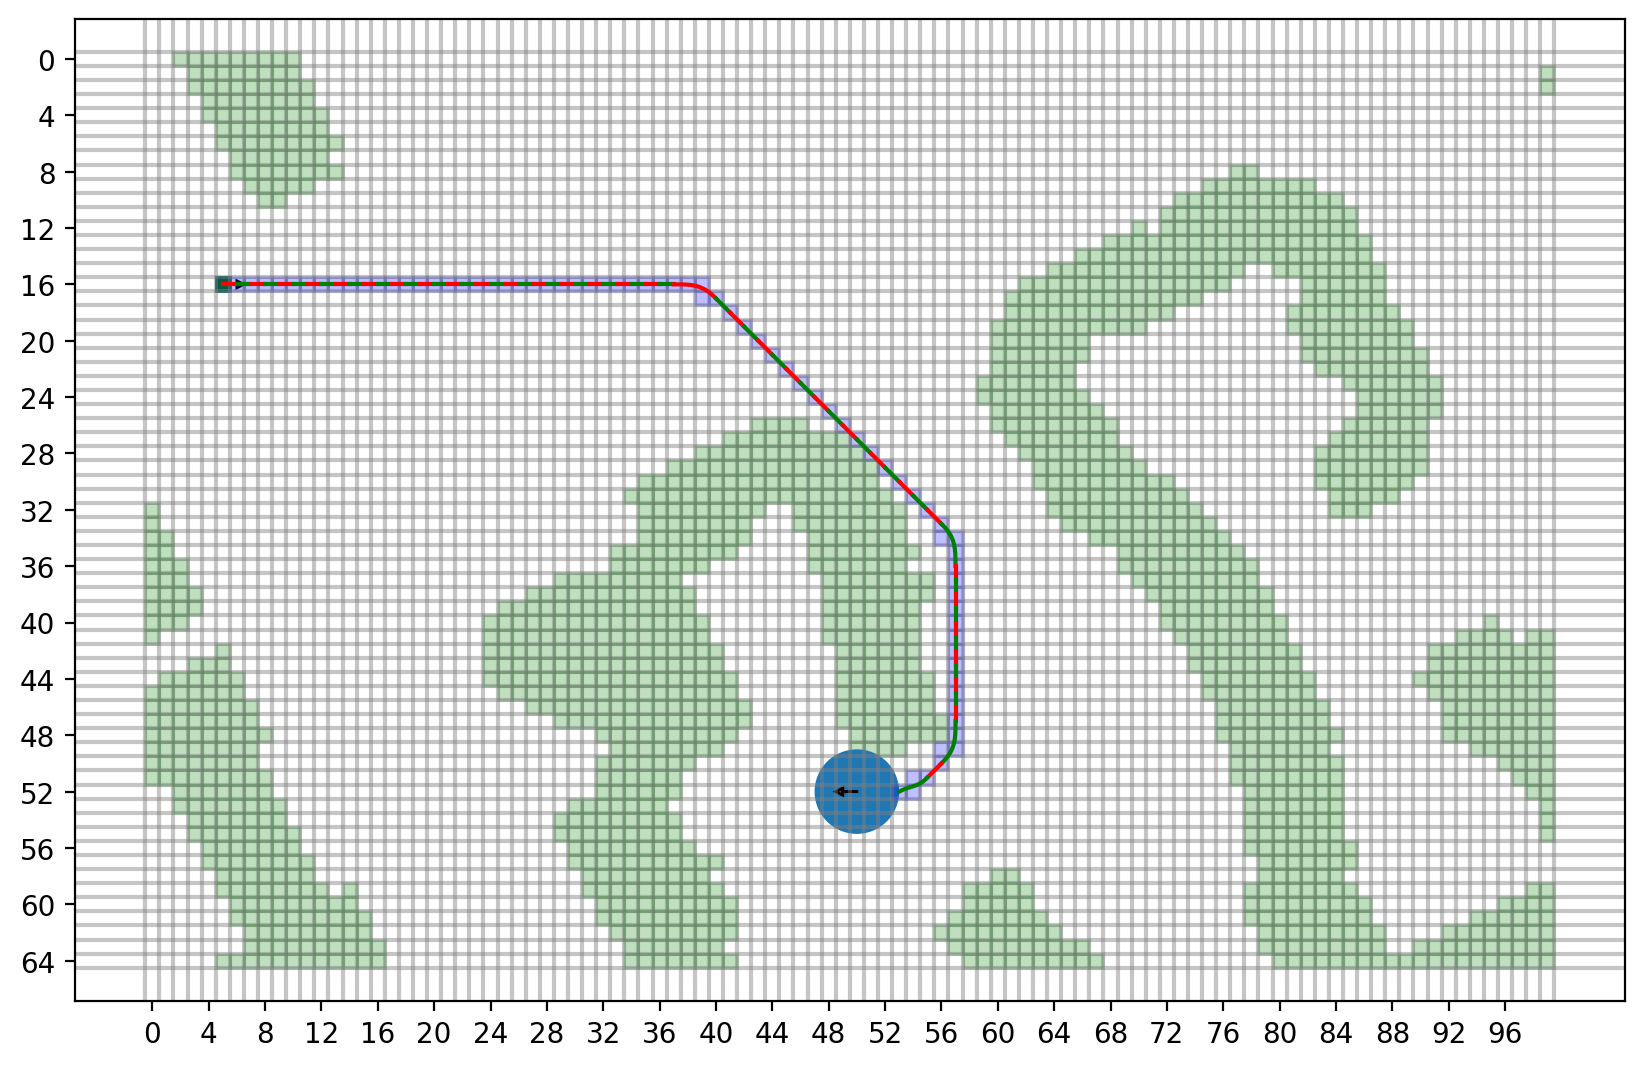

In [70]:
# третий пример

with open("Berlin_256.txt", "r") as f:
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(25,90, 50,150)
start = DiscreteState(16, 5, -0)
goal = DiscreteState(52, 50, -8)
params = TypesSearch(task_map, start, goal, short_types)

res = make_path(params)

Замечание: поиск занимает продолжительное время (около секунды, хотя тот же пример с помощью типов main_types.txt
решался меньше полусекунды). Скорее всего дело в том, что этот (short_control_set) набор примитивов очень компактный,
а потому степень ветвления на графе типов получается в среднем больше (у многих ячеек сразу по 3 соседа), чем у main_types.txt.

#### Теперь используем большой control set

In [65]:
def big_bonding_eq(self: TypeMesh, other: TypeMesh) -> bool:
    return (self.i == other.i) and (self.j == other.j) and (big_types.add_info_type[self.type] == big_types.add_info_type[other.type])

def big_bonding_hash(self: TypeMesh) -> int:
    return hash((self.i, self.j, big_types.add_info_type[self.type]))  # использум везде типы большого набора control_set

TypeMesh.__eq__ = big_bonding_eq 
TypeMesh.__hash__ = big_bonding_hash

На поиск пути затрачено время: 0.025106430053710938 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 30.0, финальное состояние: (10 24 [1])
Стоимость примитивов (длина траектории):  24.445155431257707


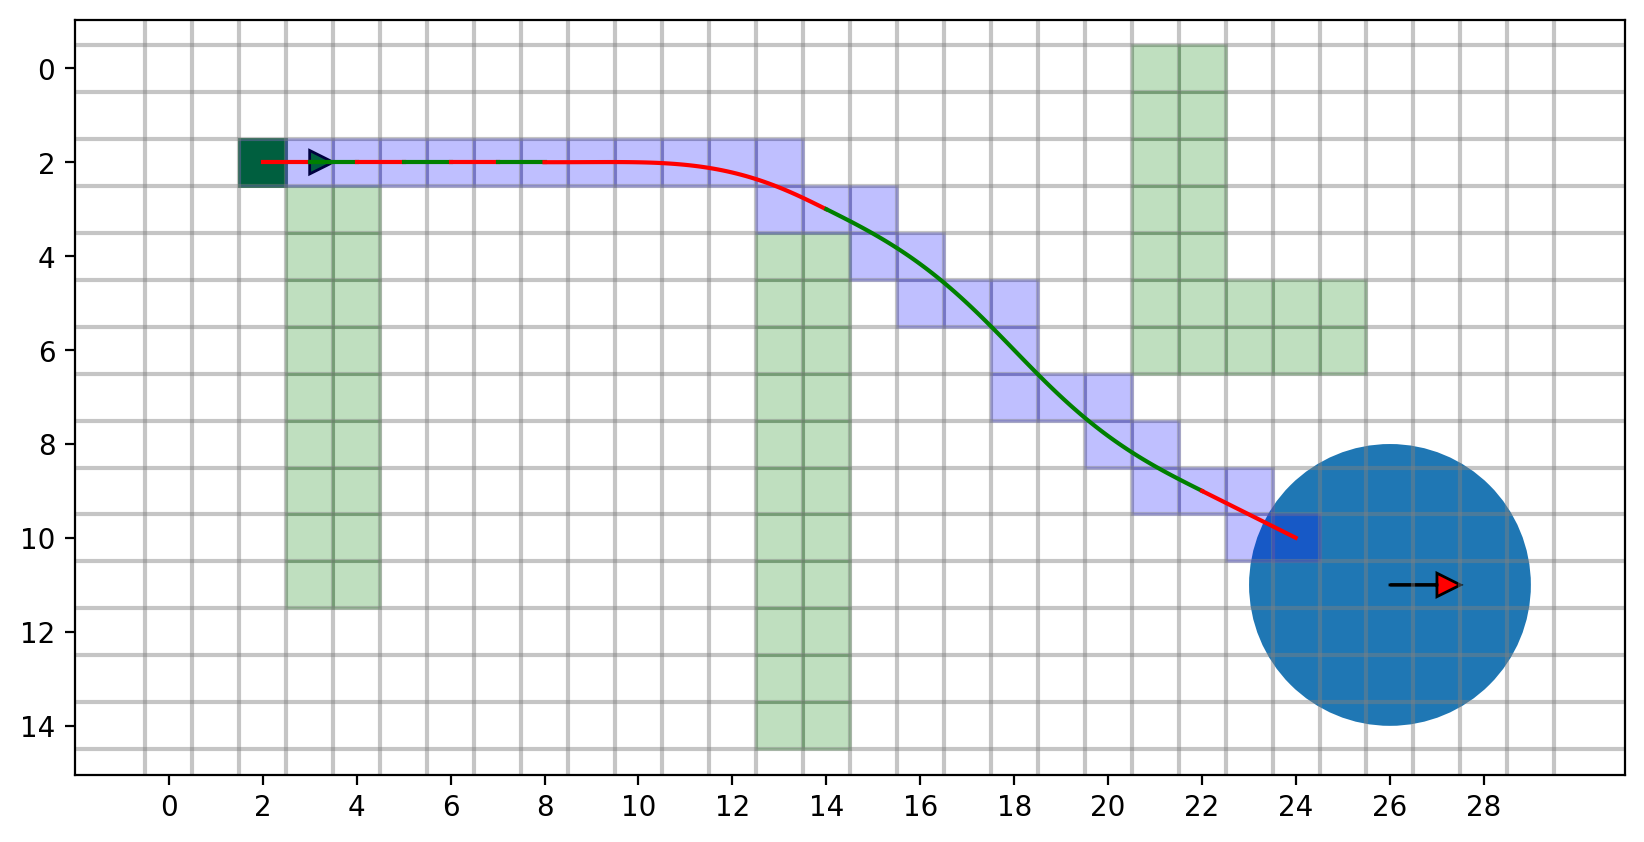

In [66]:
# Сначала посмотрим на самый первый пример

map_str =\
'''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

task_map = Map().convert_string_to_cells(map_str, obs=True)
start = DiscreteState(2, 2, -0)
goal = DiscreteState(11, 26, -0)
params = TypesSearch(task_map, start, goal, big_types)  # едиснтвенное, что меняется - используем типы для big_sontrol_set
res = make_path(params)

На поиск пути затрачено время: 0.8022935390472412 секунд
Путь найден!
Стоимость пути (= длина коллизионного следа) равна 92.0, финальное состояние: (51 52 [8])
Стоимость примитивов (длина траектории):  88.43943364440526


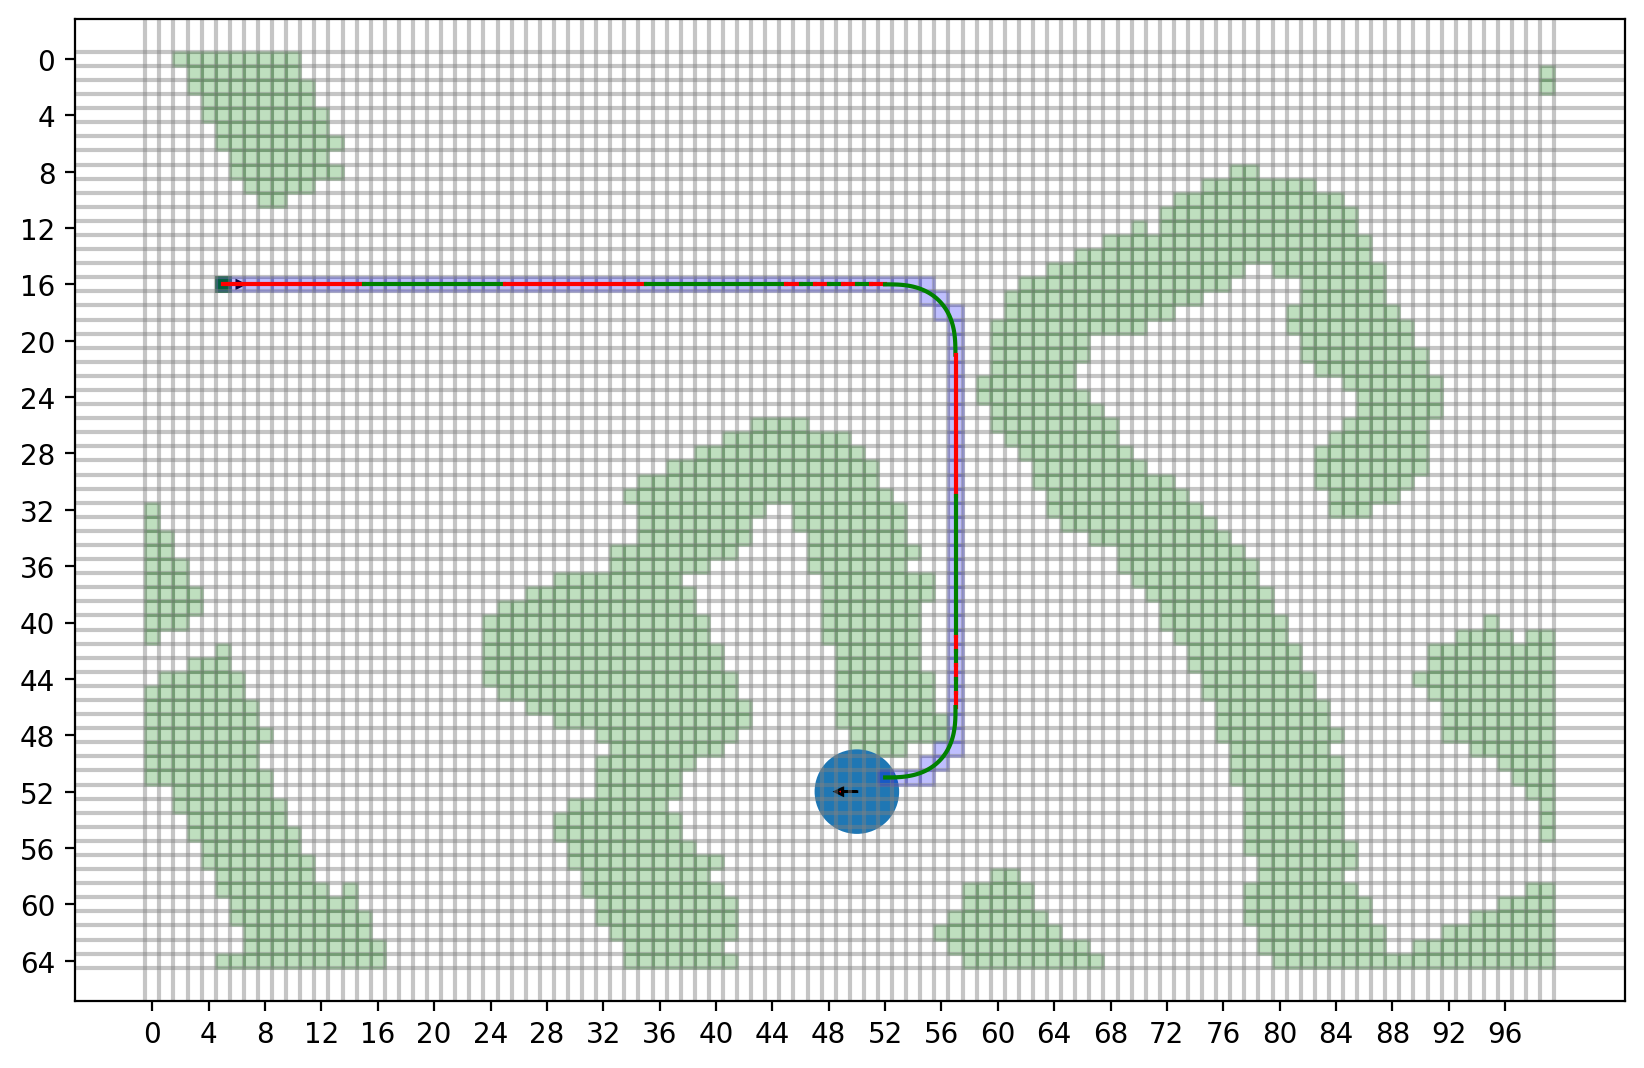

In [67]:
# третий пример

with open("Berlin_256.txt", "r") as f:
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(25,90, 50,150)
start = DiscreteState(16, 5, -0)
goal = DiscreteState(52, 50, -8)
params = TypesSearch(task_map, start, goal, big_types)

res = make_path(params)

Тут поиск тоже не быстрый, но это просто потму, что количество типов аж 1194! Поэтому сам граф типов получается очень большиим и поиск
на нем медленный.